# Importing Libraries

In [727]:
#libraries req in vscode
import numpy as np
import pandas as pd
import re
import ast









#libraries not req in vscode 
pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth',None)
import os
import plotly.express as px


#keep the output of each sklearn transformation step as a DataFrame
from sklearn import set_config
set_config(transform_output="pandas")


# Funtions

Check if multiple unique values exist across columns, else pick the first non-NaN value

In [728]:
def check_more_than_one_value_in_column(df, cols, new_col_name, col_name):
    # Step 1: Create a boolean column to check if more than one value (non-NaN) is filled in the specified columns
    df[new_col_name] = df[cols].notna().sum(axis=1) > 1

    # Step 2: Combine all values from the specified columns into a list for each row
    def combine_values():
        df[col_name] = [list(values) for values in zip(*[df[col] for col in cols])]

    combine_values()

    found_distinct = False

    # Step 3: If any row has more than one value
    if df[new_col_name].any():
        for index, row in df[col_name].items():
            non_nan_vals = [val for val in row if pd.notna(val)]
            # Step 4: If more than one unique value found in the row, print that row
            if len(set(non_nan_vals)) > 1: #take rows which have more than one unique value 
                print(f"Row {index} has multiple distinct non-NaN values: {row}") 
                found_distinct = True  #if get more than 1 distinct value then below thing wont run

    # Step 5: If no row has more than one unique value, safely pick the first non-NaN value
    if not found_distinct:
        df[col_name] = df[col_name].apply(lambda row: next((val for val in row if pd.notna(val)), None))

basic info about data 

In [729]:
def column_summary(col_name):
    print(df[col_name].head())
    print('-'*100)
    print(f'value_counts: {df[col_name].value_counts()}')
    print('-'*100)
    print(f'data type: {df[col_name].dtype}')
    print('-'*100)
    #nan values in bath column 
    print(f'Total nan values: {df[col_name].isna().sum()}')

#use 
#column_summary('bath')

for categorical columns, create new column by combining multiple and select one value

In [730]:
def combine_first_valid(df, source_cols, new_col_name):
    """
    Create a new column with the first valid (non-null, non-'nan', non-empty) value 
    across the specified source columns.
    """
    # Combine columns into new_col_name using first valid value per row
    df[new_col_name] = df[source_cols].apply(
        lambda row: next(
            (str(x) for x in row if pd.notna(x) and str(x).strip().lower() != 'nan' and str(x).strip() != ''),
            np.nan
        ),
        axis=1
    )
    # Normalize the new column's casing and whitespace
    df[new_col_name] = df[new_col_name].str.strip().str.lower()

    # Drop the source columns
    df.drop(columns=source_cols, inplace=True)

    return df

#use
# df = combine_first_valid(
#     df,
#     source_cols=['ap_pjt_name', 'many_project', 'leftmany_project'],
#     new_col_name='project_name'
# )

# Reading data 

In [731]:
mg = pd.read_csv(r'C:\Users\ABC\Desktop\bhushan\property_project\data\f_original magicbricks cleaned 12022 data.csv')

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\2767463074.py:1: DtypeWarning:

Columns (183,210,221,237,246,247,248,249,250,252,253,264,271,272,278,279,280,281,282,284,285,286,287,288) have mixed types. Specify dtype option on import or set low_memory=False.



In [732]:
mg.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12022 entries, 0 to 12021
Data columns (total 290 columns):
 #    Column                              Dtype  
---   ------                              -----  
 0    ID                                  object 
 1    @type                               object 
 2    @id                                 object 
 3    url                                 object 
 4    numberOfRooms                       float64
 5    image                               object 
 6    name                                object 
 7    geo                                 object 
 8    potentialAction                     object 
 9    address                             object 
 10   PRICE                               object 
 11   BHK_Type                            object 
 12   Area                                object 
 13   property_loc                        object 
 14   locality_URL                        object 
 15   EMI                               

In [733]:
#create a copy of original dataframe
df=mg.copy()

In [734]:
df.shape

(12022, 290)

In [735]:
df.columns

Index(['ID', '@type', '@id', 'url', 'numberOfRooms', 'image', 'name', 'geo',
       'potentialAction', 'address',
       ...
       'AM_12516', 'AM_12580', 'Commercial Office Space', '5 BHK Villa',
       'AM_12513', 'AM_12550', 'AM_12552', 'AM_12553', '3 BHK Penthouse',
       'many_Plot Area'],
      dtype='object', length=290)

# Data Cleaning

-  compare and keep only one from this -> bb_baths,leftbb_baths,bb_bath,leftbb_bath
-  comapre and keep only one from this -> 'bb_covered-parking','leftbb_covered-parking','many_car parking','leftmany_car parking'
-  compare and keep only one from this -> 'many_developer','leftmany_developer','ap_buildr'
-  compare and keep only one from this -> ap_pjt_name,many_project,leftmany_project
-  compare and keep only one from this -> 'md_furnishing','bb_unfurnished','many_furnished status','leftbb_unfurnished','leftmany_furnished status','bb_semi-furnished','leftbb_semi-furnished','bb_furnished','leftbb_furnished'
-  work on 'price' column 
-  compare and keep only one from this -> 'many_carpet area','leftmany_carpet area'
-  compare and keep only one from this -> 'leftmany_super built-up area','many_super built-up area'
-  compare and keep only one from this(property_type) -> 'many_transaction type','leftmany_transaction type'
-  compare and keep only one from this -> 'md_type of ownership', 'many_type of ownership' ,'leftmany_type of ownership'
-  compare and keep only one from this -> 'many_status', 'leftmany_status'
-  compare and keep only one from this -> 'many_lifts','md_lift','leftmany_lifts','many_lift','leftmany_lift'
-  compare and keep only one from this -> 'aboutpjt_total floors', 'md_floors allowed for construction','many_floor', 'leftmany_floor'
-  compare and keep only one from this -> 'md_age of construction', 'many_age of construction', 'leftmany_age of construction'
-  compare and keep only one from this -> 'bb_balcony', 'leftbb_balcony', 'bb_balconies','leftbb_balconies'
-  compare and keep only one from this -> 'md_additional rooms', 'leftmany_additional rooms', 'many_additional rooms'
-  compare and keep only one from this -> 'leftmany_facing', 'many_facing'
-  compare and make separate column for tower and unit -> 'ap_tower & unit','aboutpjt_total units','aboutpjt_total towers','ap_tower','ap_unit'
-  compare and keep only one from this -> 'numberofrooms','bb_beds','leftbb_beds','bb_bed','leftbb_bed'

- geo - longitude and latitude  
- potentialAction - seller:[organization,person,realestateagent] , make 3 columns like this
-  some properties are from navimumbai written in 'address' column and even then also in 'property_loc' column they written mumbai so find that and change that in  'property_loc' column and then delete "address" column
-  combine all 'am' columns together in list
- combine 'educational institute' - 'educational institute_1','educational institute_2','educational institute_3','educational institute_4','educational institute_5'
- combine 'transportation hub' - 'transportation hub_1','transportation hub_2','transportation hub_3','transportation hub_4','transportation hub_5'
- combine 'shopping centre' - 'shopping centre_1','shopping centre_2','shopping centre_3','shopping centre_4','shopping centre_5'
- combine 'commercial hub_1','commercial hub_2','commercial hub_3','commercial hub_4','commercial hub_5'
- combine 'hospital_1','hospital_2','hospital_3','hospital_4','hospital_5'
- combine 'tourist spot_1','tourist spot_2','tourist spot_3','tourist spot_4'
- work on md_overlooking
- make categories like flat and apartment from 'name' column
- emi column :convert all values in cr
- aboutpjt_project size : convert all in sqft

drop this columns :  
'@id','@type','bhk_type' ,'locality_url','md_booking amount','md_loan offered','md_water availability','ap_price','ap_price per sqft','ap_configuration','ap_pjt_url','ap_ratings','ap_reviews_by','headings_with_ratings','aboutpjt_bhk','2 bhk flat','locality_url_review','liv_environment','liv_commuting','liv_places of interest','md_status of electricity','3 bhk flat','1 bhk flat','studio apartment','4 bhk flat','5 bhk flat','md_landmarks', 'multistorey apartment', '3 bhk villa', '4 bhk villa', 'residential plot', '2 bhk builder', '3 bhk builder','4 bhk penthouse','5 bhk penthouse', 'md_authority approval','6 bhk flat','rent','commercial office space','3 bhk penthouse','md_rera id','aboutpjt_launch date'

In [736]:
#convert column names into lowercase
df.columns = df.columns.str.lower()

In [737]:
#drop unwanted columns
df= df.drop(['@id','@type','bhk_type' ,'locality_url','md_booking amount','md_loan offered','md_water availability','ap_price','ap_price per sqft','ap_configuration',
              'ap_pjt_url','ap_ratings','ap_reviews_by','headings_with_ratings','aboutpjt_bhk','2 bhk flat','locality_url_review','liv_environment','liv_commuting',
              'liv_places of interest','md_status of electricity','3 bhk flat','1 bhk flat','studio apartment','4 bhk flat','5 bhk flat','md_landmarks', 
              'multistorey apartment', '3 bhk villa', '4 bhk villa', 'residential plot', '2 bhk builder', '3 bhk builder','4 bhk penthouse','5 bhk penthouse', 
              'md_authority approval','6 bhk flat','rent','commercial office space','3 bhk penthouse','md_rera id','aboutpjt_launch date'],axis=1)

In [738]:
#check duplicate rows
print("Number of duplicate rows:", np.sum(df.duplicated()))

Number of duplicate rows: 0


In [739]:
#drop duplicate rows
df.drop_duplicates(inplace=True)

In [740]:
df.shape

(12022, 248)

In [741]:
#column which have all nan values
df.columns[df.isna().all()]

Index(['bb_unfurnished', 'leftbb_unfurnished', 'bb_semi-furnished',
       'leftbb_semi-furnished', 'bb_furnished', 'leftbb_furnished',
       '5 bhk villa', 'many_plot area'],
      dtype='object')

In [742]:
#delete column which have all nan values
df.dropna(axis=1, how='all', inplace=True) 

In [743]:
#make all string column values lowercase
df[df.select_dtypes('object').columns] = df.select_dtypes('object').apply(
    lambda col: col.map(lambda x: x.lower() if isinstance(x, str) else x)
)

In [744]:
df.shape

(12022, 240)

# numerical columns 

## price - Target column

`observation` 
- some in Cr and some price in lakhs , have to convert all of them into cr
- only Cr and Lac values in column
- drop 'md_price breakup'
- drop row where price is missing 

In [745]:
def convert_price_to_cr(val):
    if isinstance(val, str):  # check if value is a string
        parts = val.replace('₹', '').split()  # remove ₹ and split into amount and unit
        if len(parts) == 2:  # ensure both amount and unit exist
            amount, unit = parts
            amount = float(amount)  
            return amount / 100 if unit.lower() == 'lac' else amount  # convert lac to Cr
    return None  # return None if invalid

# Apply conversion
df['price'] = df['price'].apply(convert_price_to_cr)

# Drop rows with missing prices
df = df.dropna(subset=['price'])

#datatype to float
df['price'] = df['price'].astype('float64')

# Drop unnecessary column
df = df.drop(['md_price breakup'], axis=1)

# Call summary function
column_summary('price')


0    1.80
1    2.37
2    1.80
3    1.64
4    1.26
Name: price, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: price
1.250     151
1.100     148
2.500     133
1.200     130
1.500     124
1.400     124
1.750     117
1.800     115
2.000     113
0.900     111
1.900     110
1.000     110
1.350     109
0.750     109
2.250     108
0.950     106
1.300     105
1.600     105
1.700     104
2.300     103
1.150     102
3.500      98
1.850      96
0.850      92
1.650      92
0.600      91
2.100      91
1.050      91
0.700      90
0.650      89
0.800      88
0.450      83
3.000      81
1.950      80
0.400      78
2.750      76
4.500      74
0.350      74
1.450      73
1.550      73
2.800      72
2.200      71
2.600      70
2.350      70
3.250      70
4.000      69
0.550      67
2.400      67
2.700      66
0.500      64
2.150      61
6.500      59
0.720      58
0.300      58
3.100      56
5.000      55
3.750      55
5.5

## bed

`observation`
- columns -> 'numberofrooms','bb_beds','leftbb_beds','bb_bed','leftbb_bed'
- combine and keep one value else nan


In [746]:
df[['numberofrooms','bb_beds','leftbb_beds','bb_bed','leftbb_bed']].head()

,numberofrooms,bb_beds,leftbb_beds,bb_bed,leftbb_bed
0,2.0,2.0,NaN,NaN,NaN
1,3.0,NaN,3.0,NaN,NaN
2,2.0,2.0,NaN,NaN,NaN
3,2.0,2.0,NaN,NaN,NaN
4,1.0,NaN,NaN,1.0,NaN


In [747]:
check_more_than_one_value_in_column(df, ['numberofrooms', 'bb_beds', 'leftbb_beds', 'bb_bed','leftbb_bed'], 'multi_bed_filled','bed')  

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\204329741.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\204329741.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [748]:
column_summary('bed')

0    2.0
1    3.0
2    2.0
3    2.0
4    1.0
Name: bed, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: bed
2.0     4865
1.0     3191
3.0     2900
4.0      757
5.0      127
6.0       55
7.0        8
8.0        5
10.0       4
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: float64
----------------------------------------------------------------------------------------------------
Total nan values: 109


In [749]:
# Drop columns
df = df.drop(['numberofrooms','bb_beds','leftbb_beds','bb_bed','leftbb_bed','multi_bed_filled'],axis=1)

##### research more about this 
- "numberofrooms" column have missing values, in 'url' column sq-ft info there so using that I got to know that,for below 1000sq-ft, all missing values which are there in this "numberofrooms" is 1HK so hence for this 1HK we mention 0 and for above 1000 sq-ft we have to do imputation in "numberofrooms"

## Bath

`observation`
 - columns :'bb_baths','leftbb_baths','bb_bath','leftbb_bath'
 - combine all in newly created column
 - and then keep only one bath value
 - make dtype as float
 - drop unwanted columns

In [750]:
df[['bb_baths', 'leftbb_baths', 'bb_bath', 'leftbb_bath']].head()

,bb_baths,leftbb_baths,bb_bath,leftbb_bath
0,2.0,NaN,NaN,NaN
1,NaN,3.0,NaN,NaN
2,2.0,NaN,NaN,NaN
3,2.0,NaN,NaN,NaN
4,2.0,NaN,NaN,NaN


In [751]:
check_more_than_one_value_in_column(df, ['bb_baths', 'leftbb_baths', 'bb_bath', 'leftbb_bath'], 'multi_bath_filled','bath')  

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\204329741.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\204329741.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [752]:
column_summary('bath')

0    2.0
1    3.0
2    2.0
3    2.0
4    2.0
Name: bath, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: bath
2.0     6577
3.0     2487
1.0     1740
4.0      781
5.0      279
6.0       88
7.0       11
10.0       7
8.0        7
9.0        1
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: float64
----------------------------------------------------------------------------------------------------
Total nan values: 43


In [753]:
# Drop columns : 'bb_baths','leftbb_baths','bb_bath','leftbb_bath'
df = df.drop(['bb_baths','leftbb_baths','bb_bath','leftbb_bath','multi_bath_filled'],axis=1)

## Parking

comapre and keep only one from this -> 'bb_covered-parking','leftbb_covered-parking','many_car parking','leftmany_car parking'

`observation`
  - 4 columns :'bb_covered-parking','leftbb_covered-parking','many_car parking','leftmany_car parking'
  - some columns have similar data
  - max value is the correct one
  - also some columns values are like '1 Covered, 3 Open' so add only int from them so we get 4 
  - combine all columns and keep max value from them in newly created 'parking' column
  - convert into float

In [754]:
df[['bb_covered-parking','leftbb_covered-parking','many_car parking','leftmany_car parking']].head(5)

,bb_covered-parking,leftbb_covered-parking,many_car parking,leftmany_car parking
0,1.0,NaN,1 covered,NaN
1,NaN,1.0,NaN,1 covered
2,1.0,NaN,1 covered,NaN
3,NaN,NaN,NaN,NaN
4,1.0,NaN,1 covered,NaN


In [755]:
# Convert 'leftmany_car parking' into sum of all digits
df['leftmany_car parking'] = df['leftmany_car parking'].apply(
    lambda x: sum(map(int, re.findall(r'\d+', str(x)))) if pd.notna(x) else np.nan
)

# Convert 'many_car parking' into sum of all digits
df['many_car parking'] = df['many_car parking'].apply(
    lambda x: sum(map(int, re.findall(r'\d+', str(x)))) if pd.notna(x) else np.nan
)

# Take max across the four parking columns
df['parking'] = df[
    ['bb_covered-parking', 'leftbb_covered-parking', 'many_car parking', 'leftmany_car parking']
].apply(
    lambda row: np.nanmax(row.values) if pd.notna(row).any() else np.nan,
    axis=1
)

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\884482143.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



`observation`
  - more than 13 parking for single flat is not possible hence make them 'nan'
  - assign parking is not possible for below ID's hence make nan for them also ['cardid27836801' 'cardid48504695' 'cardid54247801' 'cardid63926535'
 'cardid70165891' 'cardid70404005' 'cardid71077363' 'cardid71669157'
 'cardid71832843' 'cardid72076743' 'cardid72520475' 'cardid72662033'
 'cardid72870079' 'cardid72884903' 'cardid72943753' 'cardid72963631'
 'cardid73073955' 'cardid73082695' 'cardid73099819' 'cardid73226903']

- make dtype as float

In [756]:
#None for the values which are more than 13 in parking column 
df['parking'] = df['parking'].apply(lambda x: np.nan if pd.notnull(x) and x >= 13 else x)

In [757]:
#make parking=nan for the below mention ID's
ids_to_update = [
    'cardid27836801', 'cardid48504695', 'cardid54247801', 'cardid63926535', 
    'cardid70165891', 'cardid70404005', 'cardid71077363', 'cardid71669157', 
    'cardid71832843', 'cardid72076743', 'cardid72520475', 'cardid72662033', 
    'cardid72870079', 'cardid72884903', 'cardid72943753', 'cardid72963631', 
    'cardid73073955', 'cardid73082695', 'cardid73099819', 'cardid73226903'
]

# Update 'parking' to NaN for rows where 'ID' matches
df.loc[df['id'].isin(ids_to_update), 'parking'] = np.nan

In [758]:
column_summary('parking')

0    1.0
1    1.0
2    1.0
3    NaN
4    1.0
Name: parking, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: parking
1.0     3973
2.0     1352
3.0      243
4.0       82
5.0       17
6.0        7
10.0       1
9.0        1
12.0       1
8.0        1
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: float64
----------------------------------------------------------------------------------------------------
Total nan values: 6343


In [759]:
# Drop columns : 'bb_covered-parking','leftbb_covered-parking','many_car parking','leftmany_car parking'
df = df.drop(['bb_covered-parking','leftbb_covered-parking','many_car parking','leftmany_car parking'],axis=1)

## area and costpersqft

`observation`  
- The following columns are present: 'many_carpet area','leftmany_carpet area'.  
- carpet area is mentioned in sqft,kanal and sqm .
- create new column(carpet_area) for - Extract the initial numeric values else keep nan
- convert capret_area into float
- create new column(cost_per_sqft) for - rupees per area is also included at the end of each value,following the indian rupee symbol,extract that else keep nan
- convert cost_per_sqft into float
- create new column(area_unit) for - sqft,kanal and sqm are specified at the end of each value else keep nan
- checked in excel : If value are present in 'many_carpet area', they are not present in the 'leftmany_carpet area' column at the same time.

In [760]:
#combine_first Update null elements with value in the same location in other.
df['area_work'] = df["many_carpet area"].combine_first(df["leftmany_carpet area"])

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\4121377384.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [761]:
df['area_work'].head(5)

0    635sqftsqftsqyrdsqmacrebighahectaremarlakanalbiswa1biswa2groundaankadamroodchatakkottahmarlacentperchgunthaarekathagajkillakuncham₹28,346/sqft
1                                                                                                                                               NaN
2    623sqftsqftsqyrdsqmacrebighahectaremarlakanalbiswa1biswa2groundaankadamroodchatakkottahmarlacentperchgunthaarekathagajkillakuncham₹28,892/sqft
3    702sqftsqftsqyrdsqmacrebighahectaremarlakanalbiswa1biswa2groundaankadamroodchatakkottahmarlacentperchgunthaarekathagajkillakuncham₹23,500/sqft
4    608sqftsqftsqyrdsqmacrebighahectaremarlakanalbiswa1biswa2groundaankadamroodchatakkottahmarlacentperchgunthaarekathagajkillakuncham₹20,724/sqft
Name: area_work, dtype: object

In [762]:
#cross chk done 
# area column : Extract the initial numbers using a regex 
df["carpet_area"] = df["area_work"].apply(lambda x: float(re.match(r'([\d,\.]+)', x).group(1).replace(',', '')) if pd.notna(x) and re.match(r'^[\d,\.]+', x) else None)

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\2892527437.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [763]:
column_summary('carpet_area')

0    635.0
1      NaN
2    623.0
3    702.0
4    608.0
Name: carpet_area, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: carpet_area
750.0      183
650.0      181
450.0      157
700.0      148
400.0      126
800.0      120
850.0      110
600.0      104
1100.0      95
1200.0      87
900.0       83
430.0       78
550.0       75
500.0       67
1000.0      65
950.0       63
680.0       62
425.0       60
410.0       58
620.0       52
420.0       52
1250.0      51
640.0       49
740.0       48
380.0       47
1050.0      47
1150.0      46
350.0       45
710.0       43
1300.0      43
780.0       42
660.0       42
720.0       41
470.0       40
440.0       39
670.0       38
480.0       38
690.0       37
770.0       37
760.0       35
2000.0      34
630.0       33
1600.0      33
610.0       33
675.0       33
560.0       32
415.0       32
2100.0      32
435.0       32
300.0       31
580.0       31
424.0       31
460.

In [764]:
#cross chk done
# area column : Extract the cost per sqft numbers using a regex 
df['cost_per_sqft'] = df['area_work'].str.extract(r'₹([\d,\.]+)')[0].str.replace(',', '').astype(float)

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\3477556375.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [765]:
column_summary('cost_per_sqft')

0    28346.0
1        NaN
2    28892.0
3    23500.0
4    20724.0
Name: cost_per_sqft, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: cost_per_sqft
25000.0      53
20000.0      46
30000.0      42
33333.0      35
35000.0      30
28000.0      30
50000.0      27
26667.0      26
40000.0      25
10000.0      24
31250.0      23
16667.0      22
24000.0      21
27778.0      19
13333.0      18
62500.0      17
8000.0       16
14000.0      16
27000.0      16
18000.0      16
57673.0      15
23077.0      15
37500.0      15
32000.0      14
23333.0      14
18750.0      14
16000.0      14
27273.0      14
32051.0      14
29412.0      14
42000.0      13
75000.0      13
12500.0      13
22500.0      13
29167.0      12
24444.0      12
26000.0      12
26316.0      12
22222.0      12
15385.0      12
21429.0      11
15000.0      11
14286.0      11
16981.0      11
43750.0      11
66667.0      11
36000.0      10
60000.0      10
22

In [766]:
#cross chk done
#extract area_unit 
df['area_unit'] = df['area_work'].str.extract(r'/([^/]+)$')

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\1604410422.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [767]:
column_summary('area_unit')

0    sqft
1     NaN
2    sqft
3    sqft
4    sqft
Name: area_unit, dtype: object
----------------------------------------------------------------------------------------------------
value_counts: area_unit
sqft     10147
sqm          4
kanal        1
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: object
----------------------------------------------------------------------------------------------------
Total nan values: 1869


In [768]:
df[df['area_unit']=='sqm'][['id','cost_per_sqft']]

,id,cost_per_sqft
6348,cardid54247801,112879.0
7258,cardid53926103,28289.0
9178,cardid72980775,30488.0
10168,cardid59087581,117073.0


`observation` 
- from above for sqm unit data, the cost per unit is very high 1,12,879 and if convert it into sqft then it comes in lakhs which is not correct
- hence drop this 4 rows where unit of area is sqm
- also only one row in kanal unit hence drop that also 

In [769]:
#drop rows where sqm and kanal is present
df = df[~df['area_unit'].isin(['sqm', 'kanal'])]

In [770]:
df['area_unit'].value_counts()

area_unit
sqft    10147
Name: count, dtype: int64

In [771]:
df[df['cost_per_sqft'].isna()].shape

(1869, 233)

`observation` 

 - 1870 carpet area values are unavailable
 - from observation found out that the carpet area values which are missing for that corresponding this 'leftmany_super built-up area','many_super built-up area' column values are present
 - also when 'leftmany_super built-up area' values are present then its corresponding 'many_super built-up area' values are not present and vice versa
 - now this columns are super built up area and not the carpet area ,so have to convert them into carpet area because majority values i.e 10152 carpet area values are available(doubtful done or not check later and if not done then leave it as it is)


In [772]:
#combine_first Update null elements with value in the same location in other.
df['super_build_area_work'] = df["leftmany_super built-up area"].combine_first(df["many_super built-up area"])

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\888916601.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [773]:
df['super_build_area_work'].head(5)

0                                                                                                                                                NaN
1    1905sqftsqftsqyrdsqmacrebighahectaremarlakanalbiswa1biswa2groundaankadamroodchatakkottahmarlacentperchgunthaarekathagajkillakuncham₹12,441/sqft
2                                                                                                                                                NaN
3                                                                                                                                                NaN
4                                                                                                                                                NaN
Name: super_build_area_work, dtype: object

`observation`
- some super_build_area_work values have different units at the intial position and and the end

In [774]:
#chk the units after intial digits 
df['initial_unit'] = df['super_build_area_work'].apply(lambda x: ''.join([char for char in str(x)[re.match(r'\d+', str(x)).end():] if char.isalpha()])[:4] if isinstance(x, str) else None)

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\283063975.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [775]:
df['initial_unit'].value_counts() 

initial_unit
sqft    1833
sqms       4
sqyr       1
Name: count, dtype: int64

In [776]:
#drop rows which has units : sqm and sqr (as there is only 5 rows) 
df = df[~df['initial_unit'].isin(['sqms', 'sqyr'])]

In [777]:
df['initial_unit'].value_counts() 

initial_unit
sqft    1833
Name: count, dtype: int64

In [778]:
#cross chk done 
# area column : Extract the initial numbers using a regex 
df["super_build_up_area"] = df["super_build_area_work"].apply(lambda x: float(re.match(r'([\d,\.]+)', x).group(1).replace(',', '')) if pd.notna(x) and re.match(r'^[\d,\.]+', x) else None)

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\4189825649.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [779]:
column_summary('super_build_up_area')

0       NaN
1    1905.0
2       NaN
3       NaN
4       NaN
Name: super_build_up_area, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: super_build_up_area
500.0      47
650.0      44
550.0      43
600.0      40
1000.0     31
1050.0     30
450.0      29
700.0      27
900.0      26
750.0      25
1200.0     25
850.0      21
800.0      21
1100.0     20
400.0      20
350.0      18
1500.0     16
1150.0     16
525.0      15
560.0      15
640.0      14
1250.0     14
575.0      14
2000.0     13
620.0      13
950.0      13
300.0      12
660.0      11
1300.0     11
585.0      10
1800.0     10
540.0      10
840.0      10
520.0      10
610.0      10
570.0      10
670.0       9
555.0       9
475.0       9
630.0       8
695.0       8
625.0       8
460.0       8
580.0       8
325.0       8
590.0       8
440.0       7
535.0       7
820.0       7
865.0       7
675.0       7
715.0       7
720.0       7
430.0       7
490.0  

In [780]:
#cross chk done
# area column : Extract the cost per sqft numbers using a regex 
df['super_build_up_cost_per_sqft'] = df['super_build_area_work'].str.extract(r'₹([\d,\.]+)')[0].str.replace(',', '').astype(float)

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\726135581.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [781]:
column_summary('super_build_up_cost_per_sqft')

0        NaN
1    12441.0
2        NaN
3        NaN
4        NaN
Name: super_build_up_cost_per_sqft, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: super_build_up_cost_per_sqft
20000.0     15
25000.0     14
10000.0     13
4000.0       9
57673.0      9
26667.0      9
27778.0      8
7500.0       8
6667.0       8
27000.0      8
15000.0      7
12500.0      6
50000.0      6
8182.0       6
8000.0       6
5000.0       6
16000.0      6
17000.0      5
30000.0      5
16667.0      5
6000.0       5
14000.0      5
12857.0      5
14286.0      5
7000.0       5
35000.0      5
9000.0       5
20802.0      5
28571.0      5
8333.0       4
31250.0      4
30303.0      4
6061.0       4
17857.0      4
15625.0      4
6364.0       4
23333.0      4
18000.0      4
24444.0      4
5385.0       4
5455.0       4
12000.0      4
4286.0       4
6923.0       4
9333.0       4
5556.0       4
22500.0      4
3750.0       4
24018.0      4
26380

In [782]:
#cross chk done
#extract area_unit 
df['super_built_up_area_unit'] = df['super_build_area_work'].str.extract(r'/([^/]+)$')

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\3540785301.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [783]:
df['super_built_up_area_unit'].value_counts()

super_built_up_area_unit
sqft    1833
Name: count, dtype: int64

`observation` 

 - now I make one column f_area only which has this both carpet_area and super_build_up_area
 - similarly I make one column f_costpersqft which has both this  cost_per_sqft and super_build_up_cost_per_sqft
 - combine super_built_up_area_unit and area_unit
 - I have analyze the super_build_up_area column and have 1834 data points in that , so majority of data points in data from carpet area which is 10149, now converting super_build_up_area into carpet area for 4 different region is difficult and suppose if we convert them then another problem occur which is cost_per_sqft ,because if we convert  super_build_up_area into carpet area then we have to increase cost_per_sqft and because price values are correct ,so this all makes tricky hence I finally decide to drop the super_build_up_area values  

In [784]:
#combine_first Update null elements with value in the same location in other.
df['f_area'] = df["carpet_area"].combine_first(df["super_build_up_area"])

#combine_first Update null elements with value in the same location in other.
df['f_costpersqft'] = df["cost_per_sqft"].combine_first(df["super_build_up_cost_per_sqft"])

#combine_first Update null elements with value in the same location in other.
df['f_area_unit'] = df["super_built_up_area_unit"].combine_first(df["area_unit"])

df['f_area'] = df['f_area'].astype('float')
df['f_costpersqft'] = df['f_costpersqft'].astype('float')

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\3830501051.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\3830501051.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\3830501051.py:8: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [785]:
print(f'f_area: {df['f_area'].isna().sum()}')

f_area: 30


In [786]:
print(f'f_costpersqft: {df['f_costpersqft'].isna().sum()}')

f_costpersqft: 31


In [787]:
df['f_area_unit'].value_counts()

f_area_unit
sqft    11980
Name: count, dtype: int64

`observation`:

- the 32 flats f_area and f_costpersqft data not available
- But in the Area column there is sqft data ,after cross check the data is correct for that rows 

In [788]:
df['dupli_f_area'] = np.where(
    pd.isna(df['f_area']) & pd.notna(df['area']),
    df['area'].str.extract(r'([\d,\.]+)')[0].str.replace(',', '').astype(float),
    None
)

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\907085556.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [789]:
column_summary('dupli_f_area')

0    None
1    None
2    None
3    None
4    None
Name: dupli_f_area, dtype: object
----------------------------------------------------------------------------------------------------
value_counts: dupli_f_area
4200.0    2
1000.0    2
1340.0    1
1400.0    1
3000.0    1
1442.0    1
1600.0    1
1258.0    1
740.0     1
1950.0    1
1412.0    1
500.0     1
760.0     1
1665.0    1
2700.0    1
1175.0    1
2356.0    1
3100.0    1
2675.0    1
533.0     1
2600.0    1
992.0     1
1580.0    1
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: object
----------------------------------------------------------------------------------------------------
Total nan values: 11986


In [790]:
df['dupli_f_area_unit'] = np.where(
    pd.isna(df['f_area']) & pd.notna(df['area']),
    df['area'].str.extract(r'([a-zA-Z\-]+)$')[0],
    None
)

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\4013113652.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [791]:
column_summary('dupli_f_area_unit')

0    None
1    None
2    None
3    None
4    None
Name: dupli_f_area_unit, dtype: object
----------------------------------------------------------------------------------------------------
value_counts: dupli_f_area_unit
sq-ft    25
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: object
----------------------------------------------------------------------------------------------------
Total nan values: 11986


In [792]:
df['dupli_price'] = df.apply(
    lambda row: row['price'] * (10**7) if pd.isna(row['f_area']) and pd.notna(row['area'])
    else None,
    axis=1
)

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\1153962719.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [793]:
df['dupli_price'].value_counts().sum()

25

In [794]:
df['dupli_costpersqft'] = np.round(df['dupli_price'].astype('float') / df['dupli_f_area'].astype('float'), 2)

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\2959473872.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [795]:
df['dupli_costpersqft'].value_counts()

dupli_costpersqft
14328.36     1
17763.16     1
128500.00    1
52011.10     1
41250.00     1
66136.72     1
30945.95     1
50000.00     1
66005.67     1
20000.00     1
32142.86     1
57057.06     1
25740.74     1
48000.00     1
32000.00     1
33191.49     1
25254.67     1
48387.10     1
63551.40     1
14071.29     1
100000.00    1
42307.69     1
90476.19     1
11088.71     1
39240.51     1
Name: count, dtype: int64

In [796]:
def update_values(df, update_cols, using_cols):
    for update_col, using_col in zip(update_cols, using_cols):
        df[update_col] = np.where(
            pd.isna(df['f_area']) & pd.notna(df['area']),
            df[using_col],
            df[update_col]
        )
    return df

# Define columns to update and corresponding columns to use
columns_to_update = ['f_costpersqft', 'f_area_unit', 'f_area']
using_columns = ['dupli_costpersqft', 'dupli_f_area_unit', 'dupli_f_area']

# Update the DataFrame
df = update_values(df, columns_to_update, using_columns)

In [797]:
# Drop intermediate columns
cols_to_drop = [
    'many_carpet area', 'leftmany_carpet area', 'leftmany_super built-up area', 'many_super built-up area', 'area',
    'area_work', 'carpet_area', 'cost_per_sqft', 'area_unit', 'initial_unit',
    'super_build_area_work', 'super_build_up_area', 'super_build_up_cost_per_sqft', 'super_built_up_area_unit',
    'dupli_f_area', 'dupli_f_area_unit', 'dupli_price', 'dupli_costpersqft', 'f_area_unit'
]
df.drop(columns=cols_to_drop, inplace=True)

In [798]:
df = df.rename(columns={'f_area':'area','f_costpersqft':'costpersqft'})

`obsevation`
- on excel I have done this 
(f_Area * f_costpersqft)/10000000 from this I got price of the flat and I compare this with the actual price of theflat which is price and I found some properties khave cosiderable difference 
- note that I have chk that all in sqft only 
- so that properties ID is below 
'cardid70615879','cardid69687711','cardid71143703','cardid72821117','cardid66762427','cardid72819785'

In [799]:
df.shape

(12011, 226)

In [800]:
df['area'].head()

0     635.0
1    1905.0
2     623.0
3     702.0
4     608.0
Name: area, dtype: object

In [801]:
df['price'].head()

0    1.80
1    2.37
2    1.80
3    1.64
4    1.26
Name: price, dtype: float64

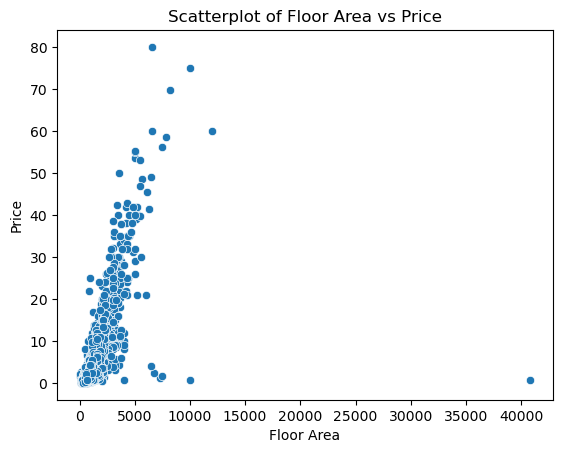

In [802]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example
sns.scatterplot(x=df['area'], y=df['price'])
plt.xlabel('Floor Area')
plt.ylabel('Price')
plt.title('Scatterplot of Floor Area vs Price')
plt.show()

In [803]:
df['area'] = df['area'].astype('float64')

In [804]:
#After analyzing, found some errors in the area column; hence, dropped the rows with the below id's
df = df[~df['id'].isin([
    'cardid13695470', 'cardid72545677', 'cardid71119645',
    'cardid46503375', 'cardid48667071', 'cardid72200975',
    'cardid70294971', 'cardid70608749', 'cardid72754063',
    'cardid72078141', 'cardid71460761', 'cardid45089373',
    'cardid71419541', 'cardid72848693', 'cardid73238137'
])]

## lift

`observation`
- columns: 'many_lifts','md_lift','leftmany_lifts','many_lift','leftmany_lift'
- combine and keep one value else nan

In [805]:
check_more_than_one_value_in_column(df, ['many_lifts', 'md_lift', 'leftmany_lifts', 'many_lift','leftmany_lift'], 'multi_lift_filled','lift')  

In [806]:
column_summary('lift')

0    4.0
1    4.0
2    2.0
3    NaN
4    3.0
Name: lift, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: lift
2.0     2388
3.0     1333
4.0     1138
1.0      631
5.0      385
6.0      305
8.0       85
7.0       78
10.0      69
9.0       56
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: float64
----------------------------------------------------------------------------------------------------
Total nan values: 5528


In [807]:
# Drop columns : 'many_lifts','md_lift','leftmany_lifts','many_lift','leftmany_lift'
df = df.drop(['many_lifts','md_lift','leftmany_lifts','many_lift','leftmany_lift','multi_lift_filled'],axis=1)

## total_floor and flat_on_floor

`observation`

- columns: 'aboutpjt_total floors', 'aboutpjt_total floors', 'md_floors allowed for construction','many_floor', 'leftmany_floor'
- from column 'md_floors allowed for construction','many_floor', 'leftmany_floor': get how many floor building has
- when 'many_floor' values are present then its corresponding 'leftmany_floor' values are not present and vice versa
- from 'many_floor', 'leftmany_floor': get flat is on which floor
- drop 'aboutpjt_total floors' column as it is wrong information

In [808]:
#combine_first Update null elements with value in the same location in other.
df['floor_work_1'] = df['many_floor'].combine_first(df['leftmany_floor'])

In [809]:
df['floor_work_1'] = df['floor_work_1'].astype('str') 

In [810]:
df['flat_on_floor'] = df['floor_work_1'].apply(
    lambda x: x.split('(')[0].strip() if '(' in str(x) else None
)

In [811]:
df['total_floor'] = df['floor_work_1'].apply(
    lambda x: x.split('(')[1].strip() if '(' in str(x) else None
)

In [812]:
df['total_floor'] = df['total_floor'].str.extract(r'(\d+)').astype(float)

In [813]:
df['flat_on_floor'] = df['flat_on_floor'].replace({'lower basement': -1, 'upper basement': -2,'ground':0})

In [814]:
df['total_floor'] = np.where(
    pd.isna(df['total_floor']) & pd.notna(df['md_floors allowed for construction']),
    df['md_floors allowed for construction'],
    df['total_floor']
)

In [815]:
column_summary('total_floor')

0     NaN
1     NaN
2     NaN
3    23.0
4     NaN
Name: total_floor, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: total_floor
7.0     1030
4.0      581
22.0     542
20.0     376
23.0     331
14.0     321
15.0     310
8.0      289
12.0     278
16.0     278
21.0     258
3.0      248
18.0     243
30.0     224
5.0      223
40.0     222
13.0     210
6.0      201
17.0     173
35.0     154
9.0      152
36.0     151
10.0     149
24.0     142
28.0     140
19.0     138
45.0     136
25.0     134
27.0     132
11.0     122
29.0     120
50.0     119
42.0     103
33.0      98
38.0      98
31.0      97
32.0      89
37.0      83
60.0      80
34.0      76
39.0      75
26.0      68
2.0       50
41.0      48
44.0      47
47.0      47
61.0      47
51.0      45
46.0      44
55.0      41
49.0      41
43.0      39
63.0      31
48.0      30
65.0      30
78.0      28
67.0      28
54.0      27
57.0      25
62.0      23
53.0     

In [816]:
column_summary('flat_on_floor')

0    None
1    None
2    None
3    None
4    None
Name: flat_on_floor, dtype: object
----------------------------------------------------------------------------------------------------
value_counts: flat_on_floor
3     694
2     689
1     644
5     641
4     621
10    588
7     564
6     512
9     390
12    369
8     363
15    334
11    317
14    243
20    228
16    214
18    201
0     201
13    176
21    144
17    144
19    131
22    126
25    121
23     97
-2     82
30     81
24     76
27     63
26     58
28     42
35     38
40     37
29     35
33     32
36     31
32     30
34     30
50     29
45     26
-1     24
37     21
38     19
39     18
41     17
42     17
31     17
44     13
47      9
48      8
60      8
46      7
43      7
52      7
62      6
68      6
55      6
57      5
56      4
51      4
70      3
66      3
49      3
58      3
54      3
53      3
61      2
73      1
75      1
71      1
65      1
Name: count, dtype: int64
--------------------------------------------------

In [817]:
df['flat_on_floor'] = df['flat_on_floor'].astype('float64')

In [818]:
# Drop columns : 'Aboutpjt_Total Floors','floor_work_1','many_Floor','leftmany_Floor'
df = df.drop(['aboutpjt_total floors','floor_work_1','many_floor','leftmany_floor','md_floors allowed for construction'],axis=1)

## balcony

`obseravation`
- columns: 'bb_balcony', 'leftbb_balcony', 'bb_balconies','leftbb_balconies'
- when one column values are present then its corresponding column values are not present

In [819]:
#combine_first Update null elements with value in the same location in other.
df['balcony'] = (
    df['bb_balcony']
    .combine_first(df['leftbb_balcony'])
    .combine_first(df['bb_balconies'])
    .combine_first(df['leftbb_balconies'])
)


In [820]:
# Drop columns
df = df.drop(['bb_balcony', 'leftbb_balcony', 'bb_balconies','leftbb_balconies'],axis=1)

In [821]:
column_summary('balcony')

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: balcony, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: balcony
1.0    3086
2.0    1468
3.0    1100
4.0     331
5.0      76
6.0      21
7.0       7
8.0       4
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: float64
----------------------------------------------------------------------------------------------------
Total nan values: 5903


## longitude and lattitude 

`observation`
- separate longitude and latitude from geo column  

In [822]:
df['lattitude'] = df['geo'].str.split(',').str[1].str.split(':').str[1].str.strip(" '\"").astype('float')

In [823]:
df['longitude'] = df['geo'].str.split(',').str[2].str.split(':').str[1].str.strip(" '\"}").astype('float')

In [824]:
df['longitude'].isna().sum()

473

**Valid values for lat and long**     
India lies to the north of the equator between **6° 44'** and **35° 30'** north latitude and **68° 7'** and **97° 25'** east longitude.  
lattitude rage - **6° 44'** and **35° 30'**  
logitude range - **68° 7'** and **97° 25'**

In [825]:
df[['lattitude','longitude']].describe()

,lattitude,longitude
count,11523.000000,11523.000000
mean,19.144404,72.905933
std,0.189232,0.087979
min,9.209138,72.704548
25%,19.062055,72.839809
50%,19.143882,72.872695
75%,19.210299,72.964031
max,19.832738,74.021019


`observation`
- The range of latitude and longitude based on the minimum and maximum values is appropriate.

In [826]:
# Drop columns
df = df.drop(['geo'],axis=1)

## emi

`observation`
- convert all emi values in lakh
- some values in 3 digit only means 700 rs so convert them also into thousand
- some values in lakh so convert then also into thousand 

In [827]:
df['emi'].head()

0      81k
1    1.07l
2      81k
3      74k
4      57k
Name: emi, dtype: object

In [828]:
df['emi'].dtype

dtype('O')

In [829]:
converted_emi = []

for emi_n in df['emi']:
    if isinstance(emi_n, str):  # Check if emi_n is a string
        if 'k' in emi_n:
            # Convert from thousands to lakhs
            converted_emi.append(float(emi_n.replace('k', '')) / 100)
        elif 'l' in emi_n:
            # No change needed for lakhs
            converted_emi.append(float(emi_n.replace('l', '')))
        else:
            # Convert rupees to lakhs
            converted_emi.append(float(emi_n) / 100000)
    else:
        # If it's already a float, convert rupees to lakhs
        converted_emi.append(emi_n / 100000)

# Add the converted values to the DataFrame
df['converted_emi'] = converted_emi
df = df.drop(['emi'], axis=1)
df.rename(columns={'converted_emi': 'emi'}, inplace=True)


In [830]:
column_summary('emi')

0    0.81
1    1.07
2    0.81
3    0.74
4    0.57
Name: emi, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: emi
0.41000     173
0.50000     169
0.32000     165
0.56000     164
0.45000     162
0.90000     162
0.54000     152
0.63000     151
0.81000     145
0.43000     143
1.13000     141
0.68000     137
0.34000     136
0.14000     135
0.79000     133
0.27000     130
0.52000     125
0.59000     123
0.61000     121
0.29000     121
0.72000     120
0.36000     120
0.77000     119
1.04000     119
0.38000     118
0.86000     118
0.83000     117
1.01000     116
0.16000     116
0.18000     114
0.95000     111
1.35000     110
0.47000     108
1.58000     108
0.74000     106
0.20000     106
0.23000     103
0.25000     100
0.65000      95
0.28000      93
0.31000      91
0.70000      91
1.24000      91
1.80000      87
0.88000      87
0.99000      85
0.40000      81
0.44000      78
1.47000      78
2.03000      77
0.970

## project_in_acres

`observation`
- aboutpjt_project size : convert all in acres

In [831]:
df['aboutpjt_project size'].isna().sum()

5845

In [832]:
df['aboutpjt_project size'].str.split(' ').str[1].value_counts()

aboutpjt_project size
acre       5522
sq-m        451
sq-ft       174
hectare       3
sq-yrd        1
Name: count, dtype: int64

In [833]:
# Conversion function for different units to acres
def convert_to_acres(value):
    if isinstance(value, str):  # Check if the value is a string
        if 'acre' in value:
            acres = float(value.replace('acre', '').strip())
            return round(acres, 4)  
        elif 'sq-m' in value:
            sqm = float(value.replace('sq-m', '').strip())
            return round(sqm * 0.000247105, 4)  
        elif 'sq-ft' in value:
            sqft = float(value.replace('sq-ft', '').strip())
            return round(sqft * 0.0000229568, 4)  
        elif 'hectare' in value:
            hectares = float(value.replace('hectare', '').strip())
            return round(hectares * 2.47105, 4)  
        elif 'sq-yrd' in value:
            sq_yrd = float(value.replace('sq-yrd', '').strip())
            return round(sq_yrd * 0.000836127, 4)  
    elif isinstance(value, (int, float)):  # If value is numeric
        return round(value * 0.0000229568, 4)  
    return np.nan

# Apply the conversion to the column
df['project_in_acres'] = df['aboutpjt_project size'].apply(lambda x: convert_to_acres(x))


In [834]:
column_summary('project_in_acres')

0     1.3006
1    17.0000
2     1.0000
3     1.0000
4     2.0000
Name: project_in_acres, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: project_in_acres
1.0000        1290
2.0000         788
3.0000         517
4.0000         418
6.0000         284
5.0000         282
8.0000         212
7.0000         203
27.0000        133
40.0000        122
18.0000        114
10.0000        104
12.0000         93
32.0000         90
17.0000         87
14.0000         71
250.0000        62
36.0000         60
9.0000          59
16.0000         48
22.0000         44
105.0000        41
15.0000         39
25.0000         39
0.2617          36
30.0000         35
3.0493          31
11.0000         29
20.0000         27
68.0000         26
1.1246          25
13.0000         25
0.0000          25
0.5807          19
0.3049          19
23.0000         19
0.2400          17
0.5141          15
1.3006          14
50.0000         14
125.

In [835]:
df = df.drop(['aboutpjt_project size'],axis=1)

# categorical columns 

## Builder 

`observation` 
 - have this many columns : 'many_developer','leftmany_developer','ap_buildr'
 - combine them and keep only one value from it else keep nan
 - dtype is object

In [836]:
#chk any ',' available before splitting in all this columns : 'many_developer','leftmany_developer','ap_buildr'
df['ap_buildr'].str.contains(',', na=False).sum()

0

In [837]:
df = combine_first_valid(
    df,
    source_cols=['many_developer','leftmany_developer','ap_buildr'],
    new_col_name='builder'
)

In [838]:
#chk if any row have more than one value or not
df['builder'].str.contains(',', na=False).sum()

0

`observation`   
same builders are written in various manner
- a&o realty / a and o realty / a & o realty ltd.
- adhiraj constructions / adhiraj constructions pvt. ltd.
- arihant superstructures ltd / arihant superstructures ltd.
- bharat infrastructure & engineering pvt. ltd. / bharat infrastructure and engineering
- bhoomi group / bhoomi / bhoomi properties
- choice group of companies / choice group
- darshan properties / darshan properties group
- dev land housing / dev land housing ltd.
- ecohomes / eco homes
- gundecha developers / gundecha / gundecha developing milestone /gundecha group
- hiranandani communities / hiranandani constructions / hiranandani developers / hiranandani group / house of hiranandani
- k raheja realty/ k. raheja realty
- krishna enterprise / krishna enterprises
- l & t realty / l&t realty
- lodha / lodha group
- lok housing group / lok group
- lokhandwala builders / Lokhandwala Constructions / lokhandwala construction industries pvt. ltd. / lokhandwala group 
- lokhandwala infrastructure
- lotus logistic and developers / lotus logistics & developer pvt ltd
- neelam realtors / neelam realtors pvt. ltd.
- neelsidhi group / neelsidhi
- nirmal lifestyle / nirmal life style
- omkar realtors and developers pvt. ltd. / omkar realtors
- parinee developers /  parinee group
- platinum group / platinum group builders / platinum constructions
- prescon group / prescon
- puraniks builders / puranik builders ltd. / puranik group
- r k builders / r k builders and developers
- qualcon properties llp / qualcon
- raheja universal (pvt.) ltd. / raheja universal pvt. ltd.
- raheja developers / raheja developers ltd.
- raj realty group / raj realty
- rashmi housing pvt. ltd. / rashmi housing
- ravi group of builders and developers / ravi group
- rna / rna ng builders / rna corp / rna group
- rohan lifescapes / rohan lifescapes ltd.
- romell group / romell real estate pvt. ltd.
- rustomjee / rustomjee developers
- sahajanand developers / sahajanand infrastructure pvt. ltd.
- sainath developers / sainath group
- sapphire group and builder / sapphire group
- saptashree builders & developers / sapta shree builders & developers
- shapoorji pallonji real estate / shapoorji pallonji group
- sheth creators / sheth creators pvt. ltd.
- shree ostwal builders ltd. / shree ostwal builders and developers
- shreedham builders and developers / shreedham group
- shreeji construction / shreeji group / shreeji group builder and developer
- smgk associates / smgk group
- space india / space india builders & developers
- spenta builders / spenta corp. pvt. ltd.
- sugee realty & developers (india) pvt. ltd. / sugee group
- swastik realtors / swastik group builders & developers
- tharwani realty / tharwani group
- titanium group / titanium builders and developers
- today global homes / today global builders & developers
- transcon developers / transcon group
- tridhaatu realty / tridhaatu realty & infra pvt. ltd.
- vaibhavlaxmi builders & developers / vaibhavlaxmi builders and developers / vaibhav laxmi developers
- vbhc value homes pvt. ltd. / vbhc
- vihang infrastructure pvt ltd / vihang group
- vinay unique developers / vinay unique group

In [839]:
def standardize_property_name(name):
    """
    Standardize property names to a single consistent name.
    """
    # Define a mapping of possible variations to standardized names
    mapping = {
        "a&o realty / a and o realty / a & o realty ltd.": "a&o realty",
        "adhiraj constructions / adhiraj constructions pvt. ltd.": "adhiraj constructions",
        "arihant superstructures ltd / arihant superstructures ltd.": "arihant superstructures ltd",
        "bharat infrastructure & engineering pvt. ltd. / bharat infrastructure and engineering": "bharat infrastructure & engineering",
        "bhoomi group / bhoomi / bhoomi properties": "bhoomi group",
        "choice group of companies / choice group": "choice group",
        "darshan properties / darshan properties group": "darshan properties",
        "dev land housing / dev land housing ltd.": "dev land housing",
        "ecohomes / eco homes": "ecohomes",
        "gundecha developers / gundecha / gundecha developing milestone /gundecha group": "gundecha group",
        "hiranandani communities / hiranandani constructions / hiranandani developers / hiranandani group / house of hiranandani": "hiranandani group",
        "k raheja realty/ k. raheja realty": "k raheja realty",
        "krishna enterprise / krishna enterprises": "krishna enterprise",
        "l & t realty / l&t realty": "l&t realty",
        "lodha / lodha group": "lodha group",
        "lok housing group / lok group": "lok housing group",
        "lokhandwala builders / lokhandwala constructions / lokhandwala construction industries pvt. ltd. / lokhandwala group": "lokhandwala group",
        "lokhandwala infrastructure": "lokhandwala infrastructure",
        "lotus logistic and developers / lotus logistics & developer pvt ltd": "lotus logistics",
        "neelam realtors / neelam realtors pvt. ltd.": "neelam realtors",
        "neelsidhi group / neelsidhi": "neelsidhi group",
        "nirmal lifestyle / nirmal life style": "nirmal lifestyle",
        "omkar realtors and developers pvt. ltd. / omkar realtors": "omkar realtors",
        "parinee developers / parinee group": "parinee group",
        "platinum group / platinum group builders / platinum constructions": "platinum group",
        "prescon group / prescon": "prescon group",
        "puraniks builders / puranik builders ltd. / puranik group": "puraniks group",
        "r k builders / r k builders and developers": "r k builders",
        "qualcon properties llp / qualcon": "qualcon",
        "raheja universal (pvt.) ltd. / raheja universal pvt. ltd.": "raheja universal",
        "raheja developers / raheja developers ltd.": "raheja developers",
        "raj realty group / raj realty": "raj realty group",
        "rashmi housing pvt. ltd. / rashmi housing": "rashmi housing",
        "ravi group of builders and developers / ravi group": "ravi group",
        "rna / rna ng builders / rna corp / rna group": "rna group",
        "rohan lifescapes / rohan lifescapes ltd.": "rohan lifescapes",
        "romell group / romell real estate pvt. ltd.": "romell group",
        "rustomjee / rustomjee developers": "rustomjee",
        "sahajanand developers / sahajanand infrastructure pvt. ltd.": "sahajanand developers",
        "sainath developers / sainath group": "sainath developers",
        "sapphire group and builder / sapphire group": "sapphire group",
        "saptashree builders & developers / sapta shree builders & developers": "saptashree",
        "shapoorji pallonji real estate / shapoorji pallonji group": "shapoorji pallonji group",
        "sheth creators / sheth creators pvt. ltd.": "sheth creators",
        "shree ostwal builders ltd. / shree ostwal builders and developers": "shree ostwal builders",
        "shreedham builders and developers / shreedham group": "shreedham group",
        "shreeji construction / shreeji group / shreeji group builder and developer": "shreeji group",
        "smgk associates / smgk group": "smgk group",
        "space india / space india builders & developers": "space india",
        "spenta builders / spenta corp. pvt. ltd.": "spenta",
        "sugee realty & developers (india) pvt. ltd. / sugee group": "sugee group",
        "swastik realtors / swastik group builders & developers": "swastik",
        "tharwani realty / tharwani group": "tharwani group",
        "titanium group / titanium builders and developers": "titanium group",
        "today global homes / today global builders & developers": "today global",
        "transcon developers / transcon group": "transcon group",
        "tridhaatu realty / tridhaatu realty & infra pvt. ltd.": "tridhaatu realty",
        "vaibhavlaxmi builders & developers / vaibhavlaxmi builders and developers / vaibhav laxmi developers": "vaibhavlaxmi builders",
        "vbhc value homes pvt. ltd. / vbhc": "vbhc",
        "vihang infrastructure pvt ltd / vihang group": "vihang group",
        "vinay unique developers / vinay unique group": "vinay unique group"
    }

    # Handle null or missing values
    if not isinstance(name, str):
        return name

    # Normalize input name (e.g., lowercase, strip whitespace)
    normalized_name = name.strip().lower()

    # Standardize using the mapping
    for key, value in mapping.items():
        variations = key.split(" / ")
        if normalized_name in variations:
            return value

    # Return the original name if no match is found
    return name

# Apply the function to the 'builder' column of a DataFrame
df['builder'] = df['builder'].apply(standardize_property_name)


In [840]:
column_summary('builder')

0                 raymond realty
1                 paradise group
2    n rose developers pvt. ltd.
3                    avant group
4                        mj shah
Name: builder, dtype: object
----------------------------------------------------------------------------------------------------
value_counts: builder
lodha group                                                       469
godrej properties                                                 277
rustomjee                                                         241
piramal realty                                                    228
oberoi realty ltd.                                                199
hiranandani group                                                 171
l&t realty                                                        154
runwal group                                                      143
kalpataru ltd.                                                    138
dosti realty                                         

## project_name

`observation` 
 - have this many columns : ap_pjt_name,many_project,leftmany_project
 - combine them and keep only one value from it else keep nan
 - dtype is object

In [841]:
#chk any ',' available before splitting in all this columns :ap_pjt_name,many_project,leftmany_project
df['leftmany_project'].str.contains(',', na=False).sum()

0

In [842]:
df = combine_first_valid(
    df,
    source_cols=['ap_pjt_name', 'many_project', 'leftmany_project'],
    new_col_name='project_name'
)

In [843]:
#chk if any row have more than one value or not
df['project_name'].str.contains(',', na=False).sum()

0

In [844]:
column_summary('project_name')

0    tenx habitat raymond realty
1      paradise sai world empire
2                 northern hills
3               avant heritage v
4                      centrionx
Name: project_name, dtype: object
----------------------------------------------------------------------------------------------------
value_counts: project_name
oberoi sky city                                                   96
piramal vaikunth                                                  90
tata serein                                                       71
omkar alta monte                                                  67
rustomjee crown                                                   66
piramal mahalaxmi                                                 65
kanakia silicon valley                                            59
rustomjee la vie                                                  57
lodha amara                                                       53
dosti eastern bay                                   

## furnish

`observation` 
  - this many columns we have : 'md_furnishing','bb_unfurnished','many_furnished status','leftbb_unfurnished','leftmany_furnished status','bb_semi-furnished','leftbb_semi-furnished','bb_furnished','leftbb_furnished'
  - Already dropped these columns as they were empty: ['bb_unfurnished', 'leftbb_unfurnished', 'bb_semi-furnished', 'leftbb_semi-furnished', 'bb_furnished', 'leftbb_furnished'].
  - so now only to perform on this columns : ['md_furnishing','many_furnished status','leftmany_furnished status']
  - combine them and keep only one value
  - dtype is object

In [845]:
#chk any ',' available before splitting in all this columns :'md_furnishing','many_furnished status','leftmany_furnished status'
df['leftmany_furnished status'].str.contains(',', na=False).sum()

0

In [846]:
df = combine_first_valid(
    df,
    source_cols=['md_furnishing','many_furnished status','leftmany_furnished status'],
    new_col_name='furnish'
)

In [847]:
#chk if any row have more than one value or not
df['furnish'].str.contains(',', na=False).sum()

0

In [848]:
column_summary('furnish')

0    unfurnished
1    unfurnished
2    unfurnished
3    unfurnished
4    unfurnished
Name: furnish, dtype: object
----------------------------------------------------------------------------------------------------
value_counts: furnish
unfurnished       7540
semi-furnished    3229
furnished         1182
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: object
----------------------------------------------------------------------------------------------------
Total nan values: 45


## city

In [849]:
df['address'].head()

0        {'@type': 'postaladdress', 'addresslocality': 'pokhran road', 'addressregion': 'thane', 'addresscountry': 'in'}
1      {'@type': 'postaladdress', 'addresslocality': 'kharghar', 'addressregion': 'navi mumbai', 'addresscountry': 'in'}
2       {'@type': 'postaladdress', 'addresslocality': 'dahisar east', 'addressregion': 'mumbai', 'addresscountry': 'in'}
3    {'@type': 'postaladdress', 'addresslocality': 'jogeshwari east', 'addressregion': 'mumbai', 'addresscountry': 'in'}
4            {'@type': 'postaladdress', 'addresslocality': 'govandi', 'addressregion': 'mumbai', 'addresscountry': 'in'}
Name: address, dtype: object

`observation`
- some properties are from navimumbai written in 'address' column and even then also in 'property_loc' column they written mumbai so find that

In [850]:
df = df.rename(columns={'address':'wholeaddress'})

df['addressregion'] = df['wholeaddress'].apply(
    lambda x: ast.literal_eval(x).get('addressregion') if isinstance(x, str) else x.get('addressregion')
)

# Drop columns
df = df.drop(['property_loc'],axis=1)

#rename
df = df.rename(columns={'md_address':'address'})

In [851]:
df = df.rename(columns = {'addressregion':'city'})

In [852]:
df['city'].value_counts()

city
mumbai         8583
thane          1633
navi mumbai    1618
palghar         162
Name: count, dtype: int64

## location

In [853]:
# Convert string representation of dictionaries to actual dictionaries
df["wholeaddress"] = df["wholeaddress"].apply(ast.literal_eval)

# Extract 'addresslocality' into a new column
df["location"] = df["wholeaddress"].apply(lambda x: x.get("addresslocality", ""))

In [854]:
df["location"].sample(10)

1658                 balkum pada
5511                        juhu
8475                     sukapur
3380     western express highway
2962                andheri west
5818              kandivali west
18                        panvel
9805            sector 20 airoli
11921               andheri east
2872                andheri west
Name: location, dtype: object

In [855]:
#make rd as road in address column
df['address'] = df['address'].astype(str).str.replace(r'\brd\b', 'road', regex=True)

In [856]:
#if below values match found in address column,then update location with the matched value

lst = [
    "mira road east", "mira road west", "mira rd east", "mira rd west",
    "vile parle east", "vile parle west", "lower parel west", "lower parel east",
    "new panvel east", "new panvel west", "grand road east", "grand road west",
    "charni road east", "charni road west", "grand rd east", "grand rd west",
    "charni rd east", "charni rd west", "kanjur marg east", "kanjur marg west",
    "mira bhayandar east", "mira bhayandar west", "marine lines east", "marine lines west",
    "ram mandir west", "ram mandir east", "vasai road west", "vasai road east",
    "matunga road west", "matunga road east", "vasai rd west", "vasai rd east",
    "matunga rd west", "matunga rd east", "rajendra nagar west", "rajendra nagar east",
    "tilak nagar west", "tilak nagar east", "diva station east", "diva station west",
    "ville parla west", "ville parla east", "lower pare west", "lower pare east",
    "mumbai central east", "mumbai central west"
]
# Step 1: Filter NaN rows
df_nan1 = df[df['location'].isna()].copy()

# Step 2 & 3: Match with lst and update location
for index, row in df_nan1.iterrows():
    for loc in lst:
        if loc in row['address'].lower():  # Case insensitive match
            df.at[index, 'location'] = loc
            break  # Stop at first match

In [857]:
# Function to extract "<name> east" or "<name> west" from 'address'
def extract_location(address):
    # Use regex to find a word followed by 'east' or 'west'
    match = re.search(r'(\w+)\s+(east|west)', address, re.IGNORECASE)
    if match:
        return f"{match.group(1)} {match.group(2)}"
    return np.nan  # If no match, return NaN

# Filter the rows where 'location' is NaN
df_nan2 = df[df['location'].isna()]

# Apply the extract_location function only to the 'address' column in the filtered rows
df.loc[df_nan2.index, 'location'] = df_nan2['address'].apply(extract_location)

In [858]:
mapping = {"near naupada police station, thane, maharashtra" : "thane west",
        "new suyash chs naupada, thane, maharashtra" : "thane west",
        "marine lines, mumbai, maharashtra" : "marine lines",
        "kalher, thane, maharashtra" : "bhiwandi",
        "kanikiya beverly park mira road, mumbai, maharashtra" : "mira road east",
        "204, 2nd flr, ramraj bldg, nr. ram mandir, rajanpada - sector-27, navi mumbai, maharashtra" : "sector 27 rajanpada",
        "202 dhrmasetu plot no 2225 sec 19 koperkhairane, navi mumbai, maharashtra" : "sector 19 koperkhairane",
        "kashimira near whestran express hyway, mumbai, maharashtra" : "mira road east",
        "near burhani college mazgaon mumbai 10, mumbai, maharashtra" : "mazgaon",
        "ulwe sector 21, navi mumbai, maharashtra" : "sector 21 ulwe",
        "lakeshore greens by lodha, thane, maharashtra" : "dombivli west",
        "santa cruz, mumbai, maharashtra" : "santacruz",
        "kopar khairane, navi mumbai, maharashtra" : "koparkhairane",
        "1801, 18th floor, chunam lane, lamington road, grantroad e, mumbai 400007, mumbai, maharashtra" : "grant road east",
        "charkop village near dingeshwar talao and jalaram temple, mumbai, maharashtra" : "kandivali west",
        "sarfaraz iqbal heights, ymca road 3, near maratha mandir, mumbai central, mumbai, maharashtra" : "mumbai central",
        "panchseel heights, mahavir nagar, mumbai, maharashtra" : "kandivali west",
        "sector 5 pushpak nagar, navi mumbai, maharashtra" : "sector 5 pushpak nagar",
        "poonam park view, global city, virar, thane, maharashtra" : "virar west",
        "om ekdant soc, sec-19, koperkharine, near jummy tower, navi mumbai, maharashtra" : "sector 19 koperkharine",
        "sai vrindhavan koparkhairne., navi mumbai, maharashtra" : "koparkhairne",
        "owale, ghodbunder road, thane, maharashtra" : "thane west",
        "sector 21 ulwe, navi mumbai, maharashtra" : "sector 21 ulwe",
        "dombivli, mumbai, maharashtra" : "dombivli",
        "amber enclave - 3rd floor thakurli e, mumbai, maharashtra" : "thakurli east",
        "anath sai apartment, thane, maharashtra" : "thane west",
        "willingdon heights 32nd flr near tardeo rto tulsiwadi, mumbai, maharashtra" : "tardeo",
        "12th floor c2 wing treetops lodha upper thane mankoli bhiwandi thane maharashtra 421302, mumbai, maharashtra" : "bhiwandi",
        "chincholi phatak, mumbai, maharashtra" : "malad west",
        "kanakiya, mumbai, maharashtra" : "kandivali east",
        "puranik hometown kasarvadavli, mumbai, maharashtra" : "thane west",
        "boraivali w 401, mumbai, maharashtra" : "borivali west",
        "prabhadevi, mumbai, maharashtra" : "prabhadevi",
        "green road, thane, maharashtra" : "thane west",
        "lagoona, thane, maharashtra" : "thane west",
        "kasarvadavli, thane, maharashtra" : "thane west",
        "kasarvadavli, thane, maharashtra" : "thane west",
        "dr annie besant road, worli, mumbai, maharashtra 400018, india, mumbai, maharashtra" : "worli",
        "gorai 2, mumbai, maharashtra" : "gorai",
        "lodha casa lakeshore green khoni dombivli, nilje gaon, maharashtra 421204, india, thane, maharashtra" : "dombivli east",
        "diamind garden chembur, mumbai, maharashtra" : "chembur",
        "sector 17 kamothe, navi mumbai, maharashtra" : "kamothe",
        "highland complex, mumbai, maharashtra" : "kandivali east",
        "jerbai wadia road, near tata hospital, parel, mumbai, maharashtra" : "parel",
        "gokhale road, naupada thane, thane, maharashtra" : "naupada",
        "taloja phase 2, navi mumbai, maharashtra" : "taloja",
        "ghansoli sector 11, navi mumbai, maharashtra" : "ghansoli",
        "ramnagar, thane, maharashtra" : "thane west",
        "ram maruti, thane, maharashtra" : "thane west",
        "marine lines, mumbai, maharashtra" : "marine lines",
        "sector 12 vashi., navi mumbai, maharashtra" : "sector 12 vashi",
        "just opposite of mansarovar railway station, navi mumbai, maharashtra" : "mansarovar",
        "bhaskar colony, thane, maharashtra" : "thane west",
        "taloja phase 2, navi mumbai, maharashtra" : "taloja",
        "charkop sector 3charkop gaon, mumbai, maharashtra" : "kandivali west",
        "157, pantnagar, 1st building naidu colony, mumbai, maharashtra" : "ghatkopar east",
        "godrej chandivali, mumbai, maharashtra" : "chandivali",
        "kalwa, thane, thane, maharashtra" : "kalwa",
        "ghansoli, navi mumbai, maharashtra" : "ghansoli",
        "suncity corner seawoodnerul, navi mumbai, maharashtra" : "nerul",
        "lagoona, thane, maharashtra" : "dombivli east",
        "satyam apartment, sector 19, kharghar, navi mumbai, maharashtra" : "kharghar",
        "tilak nagar chembur, mumbai 400089., mumbai, maharashtra" : "chembur",
        "401, sai aakash co op housing society, plot no.23, sector 18, ulwe, navi mumbai, maharashtra" : "sector 18 ulwe",
        "palava casa bella gold, mumbai, maharashtra" : "palava",
        "near vitthal mandir kharigaon kalwa, thane, maharashtra" : "kalwa",
        "kharghar, navi mumbai, maharashtra" : "kharghar",
        "neral karjat, mumbai, maharashtra" : "neral",
        "pahhal avenue, mumbai, maharashtra" : "goregaon west",
        "157, naidu colony, pantnagar, mumbai, maharashtra" : "ghatkopar east",
        "mangalmurthy complex, temghar, thane, maharashtra" : "bhiwandi",
        "plot no b1b, sector 9, airoli navimumbai, mumbai, maharashtra" : "sector 9 airoli",
        "chikhloli jambul phata, thane, maharashtra" : "chikhloli",
        "bapu nagar apartment., thane, maharashtra" : "bapu nagar",
        "crown taloja by lodha, taloja bypass phata, antarli, maharashtra 421204, mumbai, maharashtra" : "taloja",
        "morya garden residency vichumbe, navi mumbai, maharashtra" : "new panvel east",
        "sec-19, navi mumbai, maharashtra" : "sector 19 navi mumbai",
        "siddhivinayak appartment airoli diva koliwada near airoli mulund bridge diva goan gavthan, navi mumbai, maharashtra" : "airoli",  
        "kalher, thane, maharashtra" : "kalher",  
        "vinay nagar, mira road, mumbai, maharashtra" : "mira road east",
        "shree siddhivinayak tower vartaknagar, thane, maharashtra" : "vartaknagar",
        "kasarwadvali godbandar road thane, thane, maharashtra" : "kasarwadvali",  
        "panvel matheran road opp balaji symphony sukapur, navi mumbai, maharashtra" : "panvel",
        "sector 19, shahbaz gaon, cbd belapur, navi mumbai, navi mumbai, maharashtra" : "cbd belapur",
        "gamdevi grant road, mumbai, maharashtra" : "gamdevi",
        "dongri sandhurst road, mumbai, maharashtra" : "dongri",
        "casa rio arebiana, thane, maharashtra" : "thane",
        "lalani dreams residency, village dahivali turfe nid, taluka karjat, mumbai, maharashtra" : "karjat",
        "lodha crown akbar camp road kolshet mumbai maharashtra, mumbai, maharashtra" : "kolshet",  
        "202 sai shruti residency plot c 30 sector 4 khanda colony new panvel 410206, navi mumbai, maharashtra" : "new panvel",  
        "casa milano 12th floor - lodha palava phase 2 dombivali kalyan, navi mumbai, maharashtra" : "dombivli",  
        "203, sunrise glory shilphata near daighar police station, navi mumbai, maharashtra" : "shilphata", 
        "dronagiri navi mumbai., mumbai, maharashtra" : "dronagiri",  
        "muthaval, thane, maharashtra" : "muthaval",  
        "sector 5 koperkhairne navi mumbai, navi mumbai, maharashtra" : "koperkhairne",  
        "304, audumber chaya chsl, patilwadi, savarkar nagar, behind thakur college, thane, maharashtra" : "thane west",
        "old panvel near savarkar chowk., navi mumbai, maharashtra" : "old panvel",  
        "opposite j p international school haranwadi naka, mahim road, palghar, palghar, maharashtra" : "palghar",
        "tower 13 2003 runwal gardens dombivali, thane, maharashtra" : "dombivli",
        "village boisar, tal palghar, dist. thane, palghar, maharashtra" : "boisar",  
        "century bazar near chroma showroom, mumbai, maharashtra" : "century bazar",  
        "d/305., palghar, maharashtra" : "palghar",  
        "e 2 303 gaurav citymira road area, mumbai, maharashtra" : "mira road east",
        "umiya darshan chs, nerul sec 50 new, navi mumbaiseawoods, navi mumbai, maharashtra" : "seawoods",  
        "rambhau mhalgi marg, besides shrushti residency, khambalpada, thakurli e, dombivli e, thane, maharashtra" : "thakurli east",
        "ramabai paradise opp garden city tawor mira road thane, mumbai, maharashtra" : "mira road",  
        "siddhivinayak florentia garden citymira bhayandar, mumbai, maharashtra" : "mira bhayandar",  
        "bonkode sector 12, navi mumbai, maharashtra" : "sector 12 bonkode",  
        "vasant villa, padmavati devi marg, iit market, powai, mumbai 400076, mumbai, maharashtra" : "powai",  
        "novapark co opp housing society ltd flat no 303 plot no 68., navi mumbai, maharashtra" : "navi mumbai",
        "mira road area, mumbai, maharashtra" : "mira road",  
        "near divya heights in sector 26 navi mumbai, navi mumbai, maharashtra" : "sector 26 navi mumbai",
        "ganesh nagar, near boisar railway starion, palghar, maharashtra" : "boisar",  
        "c-001 nand dham building kashimira mira road, mumbai, maharashtra" : "mira road east",
        "om sankalp chs, kopar road, thane 421202, thane, maharashtra" : "dombivli west",
        "svarna kojagiri, mumbai, maharashtra" : "goregaon east",
        "unique aurum, poonam garden, thane, maharashtra" : "mira road east",
        "neelkanth darshan society b-203125a near hotel panvel palaceold panvel, mumbai, maharashtra" : "old panvel",
        "mira road kanakia, thane, maharashtra" : "mira road east",
        "panvel, navi mumbai, navi mumbai, maharashtra" : "navi mumbai",
        "chitalsar manpada, thane, maharashtra" : "manpada",  
        "near raj kamal studio, parel, mumbai, maharashtra" : "parel",  
        "nilje station road, nilje, thane, maharashtra" : "nilje", 
        "flat no-604, plot no-4, sector 14, taloja, navi mumbai, maharashtra" : "taloja",  
        "jethe tower, 701, ambawadi, opp. ambawadi bus stop, borivali e. mumbai-400068, mumbai, maharashtra" : "borivali east",  
        "lodha crown viva, flat 1006, 10th flr tower 5, majiwada, thane, mumbai, maharashtra" : "majiwada",  
        "sunbeam heritage hsg soc, sector 4c, khanda colony asudgoan panvel, navi mumbai, maharashtra" : "panvel",
        "lodha upper thane, treetops, thane, maharashtra" : "upper thane",  
        "aanandi park a101 behind ganapati mandir durgesh park kalher bhiwandi, thane, maharashtra" : "kalher",  
        "a-9/201 tejaswi apt, near st. thomas church, sai baba nagar, mira road., mumbai, maharashtra" : "mira road east",
        "sector 11, next to miraj cinema, navi mumbai, maharashtra" : "sector 11",
        "aster, regency anantham, dombivli, mumbai, maharashtra" : "dombivli",  
        "chand nagar, near baba medical, thane, maharashtra" : "thane", 
        "thane majiwada lodha complex opp-water tank, thane, maharashtra" : "majiwada",  
        "near kalidas natyamamdir, mumbai, maharashtra" : "mulund west",
        "badlapur, thane, maharashtra" : "badlapur",  
        "near mittal club, palghar, maharashtra" : "palghar",  
        "shree krupa apt flat no 102 plot144145 sector10 new panvel navi mumbai, navi mumbai, maharashtra" : "new panvel",  
        "sector 20, cbd belapur opp bank of india  park, adjacent to hansraj building, navi mumbai, maharashtra" : "sector 20 cbd belapur",  
        "brahmand patlipada link road, opp tulsi hotel, thane, maharashtra" : "thane",  
        "gurukiran socity airoli sector 30 gothavali, navi mumbai, maharashtra" : "sector 30 gothavali"}

# Fill "location" based on "address" matching mapping dictionary
df.loc[df["location"].isna(), "location"] = df["address"].map(mapping)

In [859]:
# Mapping dictionary
replace_dict = {
    "bhayander": "bhayandar",
    "century Bazar": "century bazaar",
    "dombivali": "dombivli",
    "kasarwadvali": "kasarvadavali",
    "koparkhairane": "kopar khairane",
    "koparkhairne": "kopar khairane",
    "koperkhairne": "kopar khairane",
    "koperkhairane": "kopar khairane",
    "koperkharine": "kopar khairane",
    "mulund goregaon link road": "goregaon mulund link road",
    "naigoan": "naigaon",
    "nalasopara": "nala sopara",
    "nallasopara": "nala sopara",
    "palaspe phata": "palaspa",
    "palava": "palava city",
    "shil phata": "shilphata",
    "vartaknagar": "vartak nagar",
    "vileparle": "vile parle",
    "4 east": "ulhasnagar",
    "402borivali west": "borivali west",
    "adai": "adai navi mumbai"  # Careful with this if "adai" alone is meant to be corrected
}

# Function to apply mapping
def correct_location(location):
    for wrong, correct in replace_dict.items():
        if pd.notnull(location) and wrong.lower() in location.lower():
            # Replace wrong word with correct one (case-insensitive)
            location = location.lower().replace(wrong.lower(), correct.lower())
    return location

# Apply correction function
df['location'] = df['location'].apply(correct_location)

In [860]:
#if location have this below values then update corresponding city values
location_mapping = {
    "mulund airoli road": "navi mumbai",
    "taloja bypass road": "navi mumbai",
    "panvel": "navi mumbai",
    "sector 9 airoli": "navi mumbai",
    "taloja": "navi mumbai",
    "old panvel": "navi mumbai",
    "naigaon east vasai link road": "palghar",
    "naigaon palghar": "palghar",
    "vasai": "palghar",
    "vasai east": "palghar",
    "vasai road west": "palghar",
    "vasai west": "palghar",
    "virar": "palghar",
    "virar east": "palghar",
    "virar west": "palghar",
    "thane west": "thane",
    "kolshet": "thane",
    "majiwada": "thane",
    "kandivali east": "mumbai",
    "thane belapur road": "thane",
    "mahim": "mumbai",
    "bhayandar": "thane",
    "bhayandar east": "thane",
    "bhayandar west": "thane",
    "bhayandarpada": "thane",
    "mira bhayandar": "thane",
    "mira bhayandar road": "thane",
    "mira road": "thane",
    "mira road area": "thane",
    "mira road east": "thane",
    "nala sopara": "palghar",
    "naigaon east": "palghar",
    "naigaon west": "palghar",
    "nala sopara east": "palghar",
    "nala sopara west": "palghar",
    "kharghar": "navi mumbai"
}


# Update city based on location presence
for key, value in location_mapping.items():
    df.loc[df["location"].str.contains(key, case=False, na=False), "city"] = value

In [861]:
df['location'] = df['location'].replace('', np.nan)

In [862]:
df['location'].value_counts().head()

location
mulund west       338
andheri west      298
kandivali east    285
kharghar          263
malad west        245
Name: count, dtype: int64

## property_type : New property, Resale, Rent, Other

`observation`
-  have this columns -> 'many_transaction type','leftmany_transaction type'
-  when 'many_Transaction type' values are present then its corresponding 'leftmany_Transaction type' values are not present and vice versa

In [863]:
df[['many_transaction type','leftmany_transaction type']].head()

,many_transaction type,leftmany_transaction type
0,new property,NaN
1,NaN,new property
2,new property,NaN
3,new property,NaN
4,new property,NaN


In [864]:
#combine_first Update null elements with value in the same location in other.
df['property_type'] = df["many_transaction type"].combine_first(df["leftmany_transaction type"])

In [865]:
df['property_type'].value_counts()

property_type
resale          6813
new property    5172
other              7
rent               1
Name: count, dtype: int64

In [866]:
df['property_type'].isna().sum()

3

In [867]:
df = df[~df['property_type'].isin(['other', 'rent'])]

In [868]:
# Drop columns : 'many_Transaction type','leftmany_Transaction type'
df = df.drop(['many_transaction type','leftmany_transaction type'],axis=1)

## ownership

`observation`
-  columns:  'md_type of ownership', 'many_type of ownership' ,'leftmany_type of ownership'
-  the values which are present in the 'md_type of ownership' column at the corresponding place values present in the 'many_type of ownership' and 'leftmany_type of ownership' also hence drop both this 'many_type of ownership' ,'leftmany_type of ownership' columns

1. **Freehold**: The owner has complete ownership of the property and the land it stands on, with no time limit. They can sell, transfer, or modify it without restrictions.

2. **Co-operative Society**: Ownership is collective. Residents form a society, and members own shares in it, giving them the right to reside in a unit but not outright ownership of the property.

3. **Leasehold**: The property is leased for a specific period (e.g., 99 years). Ownership remains with the lessor, and the lessee pays rent or a lease fee.

4. **Power of Attorney (POA)**: A legal authorization that allows an individual to act on behalf of the property owner. It’s often used for property transactions but doesn't equate to ownership.

In [869]:
df['md_type of ownership'].value_counts()

md_type of ownership
freehold                5944
co-operative society    2040
leasehold                317
power of attorney         28
Name: count, dtype: int64

In [870]:
df = df.rename(columns={'md_type of ownership': 'ownership'})

In [871]:
# Drop columns : 'many_type of ownership' ,'leftmany_type of ownership'
df = df.drop(['many_type of ownership' ,'leftmany_type of ownership'],axis=1)

## status

`observation`
-  columns: 'many_status', 'leftmany_status'
-  when 'many_status' values are present then its corresponding 'leftmany_status' values are not present and vice versa

In [872]:
#combine_first Update null elements with value in the same location in other.
df['status'] = df['many_status'].combine_first(df['leftmany_status'])

In [873]:
df['status'].value_counts()

status
ready to move         7337
under construction     589
ongoing                  3
Name: count, dtype: int64

In [874]:
# Drop columns : 'many_Status', 'leftmany_Status'
df = df.drop(['many_status', 'leftmany_status'],axis=1)

## construction 

`observation` 
- columns: 'md_age of construction', 'many_age of construction', 'leftmany_age of construction'
- when 'many_age of construction' values are present then its corresponding 'leftmany_age of construction' values are not present and vice versa

In [875]:
#combine_first Update null elements with value in the same location in other.
df['construction_1'] = df['many_age of construction'].combine_first(df['leftmany_age of construction'])

In [876]:
df['construction_1'].notna().sum()

3932

In [877]:
df[df['construction_1'] == df['md_age of construction']][['construction_1','md_age of construction']].shape

(3930, 2)

`observation`
- almost all values are same between construction_1 and md_age of construction columns hence drop construction_1,because md_age of construction have lesser nan values than construction_1 column 

In [878]:
df = df.rename(columns={'md_age of construction': 'construction'})

In [879]:
df['construction'].isna().sum()

1681

In [880]:
df['construction'].value_counts()

construction
under construction    3973
less than 5 years     1511
new construction      1474
5 to 10 years         1422
10 to 15 years         959
above 20 years         501
15 to 20 years         467
Name: count, dtype: int64

In [881]:
# Drop columns
df = df.drop(['construction_1','many_age of construction','leftmany_age of construction'],axis=1)

`observation`
- In the status column, the value "Under construction" is present, which we can copy to the corresponding place in the construction column. 

In [882]:
df['construction'] = df.apply(
    lambda row: 'under construction' if row['status'] == 'under construction' else row['construction'], axis=1
)

`observation`
- In the construction column, the value "under construction" is present, which we can copy to the corresponding place in the status column. 

In [883]:
df['status'] = df.apply(
    lambda row: 'under construction' if row['construction'] == 'under construction' else row['status'], axis=1
)

In [884]:
df['status'].value_counts() 

status
ready to move         7337
under construction    4562
ongoing                  3
Name: count, dtype: int64

<font color = yellow> as both status and construction column almost have similar values so chances of correlation

## extra_rooms

`observation` 

- columns: 'md_additional rooms', 'leftmany_additional rooms', 'many_additional rooms'
- when 'leftmany_Additional Rooms' values are present then its corresponding 'many_Additional Rooms' values are not present and vice versa

In [885]:
#combine_first Update null elements with value in the same location in other.
df['balcony1'] = df['leftmany_additional rooms'].combine_first(df['many_additional rooms'])

In [886]:
df['extra_room'] = df['balcony1'].str.split(' ').str[1].str.strip()

In [887]:
result = df['extra_room'].apply(
    lambda x: any(str(x) in str(room) for room in df['md_additional rooms']) if pd.notnull(x) else False
)

In [888]:
result.value_counts() 

extra_room
False    9128
True     2860
Name: count, dtype: int64

`observation`
- balcony1 column values present in the 'md_additional rooms' hence drop this balcony1 and extra_room column also and hkeep only 'md_additional rooms' column

In [889]:
#sort value alphabetically 
df['extra_rooms'] = df['md_additional rooms'].apply(
    lambda x: ', '.join(sorted(x.split(', '))) if pd.notna(x) else None
)

In [890]:
#remove none of these eg:from these 'none of these, store' and keep only store 
#but if we have only 'none of these' then we keep that as it is 
#also remove room word from all values 

df['extra_rooms'] = df['md_additional rooms'].apply(
    lambda x: x if pd.isna(x) or str(x).strip() == 'none of these' else ', '.join(
        [item.replace(' room', '') for item in str(x).split(', ') if item != 'none of these']
    )
)



In [891]:
column_summary('extra_rooms')

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: extra_rooms, dtype: object
----------------------------------------------------------------------------------------------------
value_counts: extra_rooms
none of these                  3012
store                          1114
puja                            744
study                           309
servant                         297
puja, store                     226
puja, study, store, servant     225
puja, study, store              116
store, servant                   85
puja, store, study, servant      79
puja, study                      76
study, store                     71
puja, servant                    63
puja, store, servant             55
puja, study, servant             31
study, store, servant            24
study, servant                   24
store, study                     19
puja, store, study               16
store, puja                       4
puja, study, servant, store       4
store, study, servant             3
sto

In [892]:
# final clean-up
df = df.drop(['leftmany_additional rooms', 'balcony1', 'many_additional rooms', 'extra_room', 'md_additional rooms'], axis=1)

## Facing

`observation` 
- columns:  leftmany_facing, many_facing
- when 'leftmany_facing' values are present then its corresponding 'many_facing' values are not present and vice versa

In [893]:
#combine_first Update null elements with value in the same location in other.
df['facing'] = df['leftmany_facing'].combine_first(df['many_facing'])

In [894]:
column_summary('facing')

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: facing, dtype: object
----------------------------------------------------------------------------------------------------
value_counts: facing
east            4758
north - east    1264
west             925
north            670
north - west     193
south -west      134
south - east     129
south            126
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: object
----------------------------------------------------------------------------------------------------
Total nan values: 3789


In [895]:
# Drop columns
df = df.drop(['leftmany_facing','many_facing'],axis=1)

## towers and available_units

`observation`
- columns: 'ap_tower & unit','aboutpjt_total units','aboutpjt_total towers','ap_tower','ap_unit'
- eg : 10 Towers,1512 Units : A residential project might have 10 towers, each with 151 apartments, totaling 10 × 151 = 1512 units.
- all the values which are present in 'ap_unit' are available in "aboutpjt_total units" column hence drop this 'ap_unit' column
- all the values which are present in 'ap_tower' are available in "aboutpjt_total towers" column hence drop this 'ap_tower' column
- all the values which are present in 'ap_tower & unit' are available in 'aboutpjt_total units','aboutpjt_total towers' column hence drop this 'ap_tower & unit' column
- rename 'aboutpjt_total units' as 'available_units'
- rename 'aboutpjt_total towers' 'towers'

In [896]:
df = df.rename(columns={'aboutpjt_total units': 'available_units', 
                        'aboutpjt_total towers': 'towers'})

In [897]:
column_summary('available_units')

0    1512.0
1     810.0
2     412.0
3     339.0
4     174.0
Name: available_units, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: available_units
1200.0     172
100.0      146
500.0      116
200.0      105
58.0       100
361.0       99
300.0       94
72.0        83
800.0       75
720.0       74
167.0       68
1401.0      67
400.0       65
120.0       65
298.0       55
600.0       55
250.0       51
160.0       47
60.0        46
372.0       45
252.0       44
350.0       44
152.0       44
370.0       43
220.0       42
180.0       42
1050.0      41
288.0       40
50.0        39
173.0       38
80.0        38
601.0       37
168.0       36
1000.0      34
28.0        34
379.0       34
320.0       32
552.0       32
950.0       31
90.0        31
144.0       30
450.0       30
112.0       29
432.0       29
325.0       29
475.0       28
110.0       28
476.0       28
240.0       27
192.0       27
1800.0      27
30.0  

In [898]:
column_summary('towers')

0    10.0
1     6.0
2     2.0
3     1.0
4     1.0
Name: towers, dtype: float64
----------------------------------------------------------------------------------------------------
value_counts: towers
1.0      1999
2.0      1192
3.0      1055
5.0       491
4.0       475
6.0       429
8.0       322
7.0       151
9.0       115
15.0      110
11.0       79
20.0       56
10.0       54
12.0       51
16.0       37
28.0       31
14.0       29
19.0       25
13.0       23
17.0       20
25.0       15
40.0       15
22.0       13
34.0       10
27.0       10
90.0        9
18.0        8
24.0        7
30.0        5
31.0        5
38.0        4
56.0        4
26.0        4
21.0        4
55.0        3
36.0        3
100.0       3
23.0        2
45.0        2
200.0       1
42.0        1
35.0        1
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: float64
-----------------------------------------------------------------

In [899]:
# Drop columns
df = df.drop(['ap_unit','ap_tower','ap_tower & unit'],axis=1)

## seller

`observation`
- make seller column from potentialAction column, which have this values [organization,person,realestateagent]

In [900]:
df['seller'] = df['potentialaction'].str.split(',').str[1].str.split(':').str[2].str.strip(" '\"")

In [901]:
column_summary('seller')

0       organization
1    realestateagent
2       organization
3       organization
4       organization
Name: seller, dtype: object
----------------------------------------------------------------------------------------------------
value_counts: seller
realestateagent    8117
person             3507
organization        364
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: object
----------------------------------------------------------------------------------------------------
Total nan values: 0


In [902]:
# Drop columns
df = df.drop(['potentialaction'],axis=1)

## price_category

In [903]:
# Define price bins and labels
price_bins = [0, 0.99, 1.99, 2.99, 3.99, 4.99, 5.99, 6.99, 7.99, 8.99, 9.99, 14.99, 20.00, float('inf')]
price_labels = [
    "0.00 - 0.99", "1.00 - 1.99", "2.00 - 2.99", "3.00 - 3.99", "4.00 - 4.99", 
    "5.00 - 5.99", "6.00 - 6.99", "7.00 - 7.99", "8.00 - 8.99", "9.00 - 9.99", 
    "10.00 - 14.99", "15.00 - 20.00", "20.00 and above"
]

# Use pd.cut to categorize the prices
df['price_category'] = pd.cut(df['price'], bins=price_bins, labels=price_labels, right=True)

# Count the occurrences in each category
category_counts = df['price_category'].value_counts().sort_index()

# Print the result
print(category_counts)

price_category
0.00 - 0.99        3257
1.00 - 1.99        3467
2.00 - 2.99        1999
3.00 - 3.99        1075
4.00 - 4.99         571
5.00 - 5.99         415
6.00 - 6.99         295
7.00 - 7.99         189
8.00 - 8.99         140
9.00 - 9.99         102
10.00 - 14.99       242
15.00 - 20.00       109
20.00 and above     127
Name: count, dtype: int64


In [904]:
# Create a pivot table to show the average price for each combination of construction category and address region
pivot_table = df.pivot_table(values='price', index='price_category', columns='city', aggfunc='count')

# Display the pivot table
print(pivot_table)

city             mumbai  navi mumbai  palghar  thane
price_category                                      
0.00 - 0.99         877          877      525    978
1.00 - 1.99        2244          457        9    757
2.00 - 2.99        1631          172        0    196
3.00 - 3.99         935           67        1     72
4.00 - 4.99         524           24        0     23
5.00 - 5.99         390           13        0     12
6.00 - 6.99         284            5        0      6
7.00 - 7.99         184            1        0      4
8.00 - 8.99         138            2        0      0
9.00 - 9.99         101            1        0      0
10.00 - 14.99       241            0        0      1
15.00 - 20.00       109            0        0      0
20.00 and above     127            0        0      0


C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\3705261046.py:2: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [905]:
column_summary('price_category')

0    1.00 - 1.99
1    2.00 - 2.99
2    1.00 - 1.99
3    1.00 - 1.99
4    1.00 - 1.99
Name: price_category, dtype: category
Categories (13, object): ['0.00 - 0.99' < '1.00 - 1.99' < '2.00 - 2.99' < '3.00 - 3.99' ... '9.00 - 9.99' < '10.00 - 14.99' < '15.00 - 20.00' < '20.00 and above']
----------------------------------------------------------------------------------------------------
value_counts: price_category
1.00 - 1.99        3467
0.00 - 0.99        3257
2.00 - 2.99        1999
3.00 - 3.99        1075
4.00 - 4.99         571
5.00 - 5.99         415
6.00 - 6.99         295
10.00 - 14.99       242
7.00 - 7.99         189
8.00 - 8.99         140
20.00 and above     127
15.00 - 20.00       109
9.00 - 9.99         102
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: category
----------------------------------------------------------------------------------------------------
Total nan values: 0


`observation`
- High-price properties missing in Navi Mumbai, Thane, and Palghar → No properties above ₹6 Cr in these regions.    
- Palghar lacks high-price properties → No properties beyond ₹1 Cr in Palghar.    
- Feature engineering per region → Need to handle each feature differently based on city.    
- Price variation by region → To avoid bias, process data considering both city and price.    
- Combine 'am' columns → Group all columns with 'am' into a single list for efficient handling.    

## Overlooking

`observation`
-  md_overlooking : rename

In [906]:
df['md_overlooking'].value_counts()

md_overlooking
main road                       2266
garden/park, main road          1739
garden/park                     1540
garden/park, pool, main road    1423
garden/park, pool                393
pool, garden/park, main road     254
pool                             102
pool, main road                   60
main road, garden/park            59
pool, garden/park                 58
main road, garden/park, pool      55
garden/park, main road, pool       9
pool, main road, garden/park       7
main road, not available           2
main road, pool, garden/park       1
Name: count, dtype: int64

In [907]:
df['overlooking'] = df['md_overlooking'].apply(
    lambda x: ', '.join(sorted(map(str.strip, x.split(',')))) if pd.notna(x) else np.nan
)

In [908]:
# Remove the phrase 'not available' from the 'overlooking' column
df['overlooking'] = df['overlooking'].str.replace(',? *not available', '', regex=True)

In [909]:
column_summary('overlooking')

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: overlooking, dtype: object
----------------------------------------------------------------------------------------------------
value_counts: overlooking
main road                       2268
garden/park, main road          1798
garden/park, main road, pool    1749
garden/park                     1540
garden/park, pool                451
pool                             102
main road, pool                   60
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: object
----------------------------------------------------------------------------------------------------
Total nan values: 4020


In [910]:
# Drop the original column if no longer needed
df = df.drop(columns=['md_overlooking'])

In [911]:
df.shape

(11988, 202)

## room_type

`observation`  
-make categories like flat and apartment from 'name' column 

In [912]:
df['room_type'] = df['name'].apply(lambda x: 'flat' if 'flat' in x else ('apartment' if 'apartment' in x else 'other'))

In [913]:
df['room_type'].value_counts()

room_type
flat         11879
apartment      109
Name: count, dtype: int64

In [914]:
(df['room_type'].value_counts()) / len(df['room_type']) *100

room_type
flat         99.090757
apartment     0.909243
Name: count, dtype: float64

`observation`  
- Flats make up the majority (99%), while apartments account for only 1%. Therefore, we should drop the apartment rows. Since the entire column will then contain only flats, it is no longer needed and can also be dropped.  
- There are no missing values.

In [915]:
#drop apartment rows
df = df[df['room_type'] != 'apartment']

In [916]:
column_summary('room_type')

0    flat
1    flat
2    flat
3    flat
4    flat
Name: room_type, dtype: object
----------------------------------------------------------------------------------------------------
value_counts: room_type
flat    11879
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
data type: object
----------------------------------------------------------------------------------------------------
Total nan values: 0


`observation`
- only one unique value → drop this column

In [917]:
df.drop(columns='room_type', inplace=True)

In [918]:
df.shape

(11879, 202)

## nearby_location_km

`observation`
- combine 'educational institute' - 'educational institute_1','educational institute_2','educational institute_3','educational institute_4','educational institute_5'
- combine 'transportation hub' - 'transportation hub_1','transportation hub_2','transportation hub_3','transportation hub_4','transportation hub_5'
- combine 'shopping centre' - 'shopping centre_1','shopping centre_2','shopping centre_3','shopping centre_4','shopping centre_5'
- combine 'commercial hub_1','commercial hub_2','commercial hub_3','commercial hub_4','commercial hub_5'
- combine 'hospital_1','hospital_2','hospital_3','hospital_4','hospital_5'
- combine 'tourist spot_1','tourist spot_2','tourist spot_3','tourist spot_4'

- Will create 5 new columns from existing features.
- From `*_mean_km` columns:
  - Create a column with the minimum value across all `*_mean_km` columns.
  - Create a column with the mean value across all `*_mean_km` columns.
- From `*_min_km` columns:
  - Create a column with the minimum value across all `*_min_km` columns.
  - Create a column with the mean value across all `*_min_km` columns.
- From `*_within_2km` columns:
  - Create a column with the sum of all `*_within_2km` values (row-wise) to count total nearby facilities (≤ 2 km).

In [919]:
# Reusable function
def combine_columns(df, cols, new_col):
    df[new_col] = df[cols].apply(
        lambda row: ', '.join(filter(pd.notna, row)) if any(pd.notna(row)) else np.nan,
        axis=1
    )

# Education
combine_columns(df, [
    'educational institute_1', 'educational institute_2', 
    'educational institute_3', 'educational institute_4', 
    'educational institute_5'
], 'education')

# Transport
combine_columns(df, [
    'transportation hub_1', 'transportation hub_2', 
    'transportation hub_3', 'transportation hub_4', 
    'transportation hub_5'
], 'transport')

# Shopping Centre
combine_columns(df, [
    'shopping centre_1', 'shopping centre_2', 
    'shopping centre_3', 'shopping centre_4', 
    'shopping centre_5'
], 'shopping_centre')

# Commercial Hub
combine_columns(df, [
    'commercial hub_1', 'commercial hub_2', 
    'commercial hub_3', 'commercial hub_4', 
    'commercial hub_5'
], 'commercial_hub')

# Hospital
combine_columns(df, [
    'hospital_1', 'hospital_2', 
    'hospital_3', 'hospital_4', 
    'hospital_5'
], 'hospital')

# Tourist
combine_columns(df, [
    'tourist spot_1', 'tourist spot_2', 
    'tourist spot_3', 'tourist spot_4'
], 'tourist')

In [920]:
# Function to extract mean km from text
# Initialize global zero counter
zero_count = 0

# Function to extract mean km with zero replacement
def extract_mean_km(text):
    global zero_count
    if pd.isna(text):
        return np.nan
    km_values = [float(x) for x in re.findall(r'([\d.]+)\s*km', text)]
    if any(km == 0.0 for km in km_values):
        zero_count += 1
        km_values = [0.0001 if km == 0.0 else km for km in km_values] #reason for this code given below 
    return sum(km_values) / len(km_values) if km_values else np.nan

# Function to extract min km with zero replacement
def extract_min_km(text):
    if pd.isna(text):
        return np.nan
    km_values = [float(x) for x in re.findall(r'([\d.]+)\s*km', text)]
    km_values = [0.0001 if km == 0.0 else km for km in km_values]
    return min(km_values) if km_values else np.nan

# Apply to column
df['education_mean_km'] = df['education'].apply(extract_mean_km)
df['education_min_km'] = df['education'].apply(extract_min_km)

# Print your zero count!
#print(f"\nRows containing zero km replaced: {zero_count}") #print no of zero km values in data , 
                                                            #means something which is in zero km , like hospital in building so it become zero km
                                                            #for such data make 0.0001 km just make identify them as there is location of hospital or any other 
                                                            #if we keep 0 km only then it may means that there is no location for that property 
                                                            #if any there is hospital location which is inside building or something then it become 0.0 km so this get counut as 1
                                                            #in hospital_within_2km


# Function to count places within 2 km
#so one row has so many values and from that how many are within 2km that we count here
#eg: [1.0,3.0,1.9,4.8] so here it is 2
def count_within_2km(text):
    if pd.isna(text):
        return np.nan
    km_values = [float(x) for x in re.findall(r'([\d.]+)\s*km', text)]
    return sum(1 for km in km_values if km <= 2.0)

# List of combined location columns
location_cols = ['education', 'transport', 'shopping_centre', 'commercial_hub', 'hospital', 'tourist']

# Apply all 3 functions: mean, min, within_2km
for col in location_cols:
    df[col + '_mean_km'] = df[col].apply(extract_mean_km)
    df[col + '_min_km'] = df[col].apply(extract_min_km)
    df[col + '_within_2km'] = df[col].apply(count_within_2km)

# Show only mean and min columns
mean_cols = [col + '_mean_km' for col in location_cols]
min_cols = [col + '_min_km' for col in location_cols]
within_2km_cols = [col + '_within_2km' for col in location_cols]

# Add final 5 summary columns
df['overall_min_mean_km'] = df[mean_cols].min(axis=1)
df['overall_avg_mean_km'] = df[mean_cols].mean(axis=1)
df['overall_min_min_km'] = df[min_cols].min(axis=1)
df['overall_avg_min_km'] = df[min_cols].mean(axis=1)
df['total_within_2km'] = df[within_2km_cols].sum(axis=1) #sum of all within_2km location_cols

# Show result
print(df[mean_cols + min_cols + within_2km_cols + [
    'overall_min_mean_km', 'overall_avg_mean_km',
    'overall_min_min_km', 'overall_avg_min_km',
    'total_within_2km'
]].head())

   education_mean_km  transport_mean_km  shopping_centre_mean_km  \
0           1.833333           5.050000                     2.25   
1           3.040000           2.760000                     4.12   
2           7.525000          10.266667                     5.38   
3                NaN                NaN                      NaN   
4           2.060000           1.200000                     3.85   

   commercial_hub_mean_km  hospital_mean_km  tourist_mean_km  \
0                     NaN               NaN              NaN   
1                     6.0               NaN              NaN   
2                    18.5               NaN              NaN   
3                     NaN               NaN              NaN   
4                     NaN               NaN              NaN   

   education_min_km  transport_min_km  shopping_centre_min_km  \
0               1.2               3.0                     2.1   
1               1.1               1.9                     2.3   
2          

`observation`
- transport_within_2km is 0.0 means there are places more than 2km , same for other _within_2km columns also 

In [921]:
# #delete if above code work properly 
# #final code 
# # Function to extract mean km from text
# def extract_mean_km(text):
#     if pd.isna(text):
#         return np.nan
#     km_values = [float(x) for x in re.findall(r'([\d.]+)\s*km', text)]
#     return sum(km_values) / len(km_values) if km_values else np.nan

# # Function to extract min km from text
# def extract_min_km(text):
#     if pd.isna(text):
#         return np.nan
#     km_values = [float(x) for x in re.findall(r'([\d.]+)\s*km', text)]
#     return min(km_values) if km_values else np.nan

# # Function to count places within 2 km
# #so one row has so many values and from that how many are within 2km that we count here
# #eg: [1.0,3.0,1.9,4.8] so here it is 2
# def count_within_2km(text):
#     if pd.isna(text):
#         return np.nan
#     km_values = [float(x) for x in re.findall(r'([\d.]+)\s*km', text)]
#     return sum(1 for km in km_values if km <= 2.0)

# # List of combined location columns
# location_cols = ['education', 'transport', 'shopping_centre', 'commercial_hub', 'hospital', 'tourist']

# # Apply all 3 functions: mean, min, within_2km
# for col in location_cols:
#     df[col + '_mean_km'] = df[col].apply(extract_mean_km)
#     df[col + '_min_km'] = df[col].apply(extract_min_km)
#     df[col + '_within_2km'] = df[col].apply(count_within_2km)

# # Show only mean and min columns
# mean_cols = [col + '_mean_km' for col in location_cols]
# min_cols = [col + '_min_km' for col in location_cols]
# within_2km_cols = [col + '_within_2km' for col in location_cols]

# # Add final 5 summary columns
# df['overall_min_mean_km'] = df[mean_cols].min(axis=1)
# df['overall_avg_mean_km'] = df[mean_cols].mean(axis=1)
# df['overall_min_min_km'] = df[min_cols].min(axis=1)
# df['overall_avg_min_km'] = df[min_cols].mean(axis=1)
# df['total_within_2km'] = df[within_2km_cols].sum(axis=1) #sum of all within_2km location_cols

# # Show result
# print(df[mean_cols + min_cols + within_2km_cols + [
#     'overall_min_mean_km', 'overall_avg_mean_km',
#     'overall_min_min_km', 'overall_avg_min_km',
#     'total_within_2km'
# ]].head())

In [922]:
# Your list of columns
columns = [
    'education_mean_km', 'education_min_km', 'education_within_2km',
    'transport_mean_km', 'transport_min_km', 'transport_within_2km',
    'shopping_centre_mean_km', 'shopping_centre_min_km', 'shopping_centre_within_2km',
    'commercial_hub_mean_km', 'commercial_hub_min_km', 'commercial_hub_within_2km',
    'hospital_mean_km', 'hospital_min_km', 'hospital_within_2km',
    'tourist_mean_km', 'tourist_min_km', 'tourist_within_2km',
    'overall_min_mean_km', 'overall_avg_mean_km',
    'overall_min_min_km', 'overall_avg_min_km', 'total_within_2km'
]


# total notnull bvalues in above columns 
non_null_counts = df[columns].notnull().sum().sum()
print(non_null_counts)


# total values which are greater than 10km in above columns 
more_than_20km_counts = (df[columns] > 10).sum().sum()
print(more_than_20km_counts)

143080
7984


`observation`
- more than 10km locations such as education,transport,hospital are there but there are less than 10km also all this locations are there in mumbai,thane,navi mumbai and palghar
- so what will do is we use 3 ways  
- remove more than 10km values and then do missing value imputation
- keep more than 10km values and then do missing value imputation
- remove this columns outliers using IQR and then do missing value imputation

In [923]:
# Drop columns
df = df.drop(['educational institute_1','educational institute_2','educational institute_3','educational institute_4','educational institute_5',
             'transportation hub_1','transportation hub_2','transportation hub_3','transportation hub_4','transportation hub_5','shopping centre_1',
             'shopping centre_2','shopping centre_3','shopping centre_4','shopping centre_5','commercial hub_1','commercial hub_2','commercial hub_3',
             'commercial hub_4','commercial hub_5','hospital_1','hospital_2','hospital_3','hospital_4','hospital_5','tourist spot_1','tourist spot_2',
             'tourist spot_3','tourist spot_4','education', 'transport', 'shopping_centre', 'commercial_hub', 'hospital', 'tourist'],axis=1)

In [924]:
df.shape

(11879, 196)

## flooring 

`observation` 
- 37% missing values 
- still I make feature engineering on that and I have make that using two different approach  
  - 1st Approach : Kmeans clustering 
    - using MultiLabelBinarizer create binary features
    - apply kmeans and find cluster
  - 2nd Approach : avg weightage for each flooring
    - assign weightage to each flooring according to the cost and quality of the material
    - cal sum of weightage for each data points 

In [925]:
df = df.rename(columns={'md_flooring':'flooring'})

In [926]:
df['flooring'].dtype

dtype('O')

In [927]:
df['flooring'].value_counts()

flooring
vitrified                                                                                         3671
marble                                                                                             691
ceramic tiles                                                                                      329
vitrified, wooden                                                                                  168
granite, vitrified                                                                                 134
marble, vitrified                                                                                  129
ceramic tiles, vitrified                                                                           113
vitrified, marble, granite                                                                          94
vitrified, ceramic tiles                                                                            94
ceramic tiles, granite, vitrified                               

In [928]:
df['flooring'].isnull().sum()

4442

### method 1 : Kmeans clustering 

note : this method we can apply after train test split

I have perform this method in mg_model_building ipynb notebook already

### method 2 : assign weightage 

note : this method we can apply before train test split but in feature engineering 

I have perforrm this method in mg_feature_engineering.ipynb notebook already

## amenities

In [929]:
columns_with_am = [col for col in df.columns if col.startswith('am')]

In [930]:
columns_with_am

['am_12204',
 'am_12226',
 'am_12225',
 'am_12229',
 'am_12230',
 'am_1404107',
 'am_12201',
 'am_12205',
 'am_12202',
 'am_12209',
 'am_12207',
 'am_12208',
 'am_12214',
 'am_12216',
 'am_12218',
 'am_1404110',
 'am_12224',
 'am_12206',
 'am_1404117',
 'am_1404105',
 'am_12220',
 'am_12228',
 'am_12203',
 'am_12211',
 'am_1404118',
 'am_1404106',
 'am_1404125',
 'am_1404124',
 'am_12538',
 'am_12540',
 'am_12219',
 'am_12227',
 'am_12523',
 'am_12533',
 'am_12534',
 'am_12535',
 'am_12536',
 'am_12537',
 'am_12539',
 'am_12543',
 'am_12545',
 'am_12581',
 'am_12583',
 'am_1404155',
 'am_1404114',
 'am_1404143',
 'am_1404109',
 'am_1404131',
 'am_12212',
 'am_1404112',
 'am_12217',
 'am_1404116',
 'am_1404120',
 'am_1404111',
 'am_12222',
 'am_1404115',
 'am_1404123',
 'am_1404127',
 'am_1404128',
 'am_1404129',
 'am_12223',
 'am_12215',
 'am_1404108',
 'am_12213',
 'am_12221',
 'am_1404130',
 'am_1404126',
 'am_1404113',
 'am_1404122',
 'am_12586',
 'am_1404156',
 'am_12525',
 'am_125

### method 1 :kmeans 

note : this method we can apply after train test split

I have perform this method in mg_model_building ipynb notebook already

### method 2 : assign weightage

note : this method we can apply before train test split but in feature engineering 

I have perforrm this method in mg_feature_engineering.ipynb notebook already

### method 3: actual weightage

note : this method we can apply after train test split

I have perform this method in mg_model_building ipynb notebook already

note : use this method only after this structure   
so before using below code make sure that this steps are compulsory you have to do then use below code 

1. Handle Missing Values (e.g., SimpleImputer, KNNImputer, or domain-specific methods)
2. Apply Train-CV-Test Split then Compute Weightage for extra_rooms (using the training set) then Use Weightage in CV and Test Sets (for this code is below)
3. Proceed with Model Training & Evaluation

I've structured the code like this  
1. **Train-test split per `city`**.
2. **Group the train data by `city`**.
3. **Calculate weightages per region based on the training data**.
4. **Apply these weightages to both the train and test sets**.

`observation`  
- Performed 3 different methods to convert the amenities column into numerical form:
  - Method 1 : Kmeans 
  - Method 2 : Assign weightage  
  - Method 3 : Actual weightage  
- Evaluate which method gives the best model performance and keep that as the final approach.
- temproy I made this below 

`observation`
- For now, will do this below and then join these columns later in feature engineering and model building.
- Original `df` contains `id` and columns starting with `am_`.
- Created `am_df` with `id` and all columns starting with `am_`.
- Dropped `am_` columns from original `df`, but kept `id`.

In [931]:
# Select columns that start with 'am_' and include 'id'
am_cols = ['id'] + [col for col in df.columns if col.startswith('am_')]

# Create a separate DataFrame with those columns
am_df = df[am_cols].copy()

# Drop 'am_' columns from the original DataFrame (keep 'id')
df = df.drop(columns=[col for col in df.columns if col.startswith('am_')])

In [932]:
# #delete
# # save the cleaned data

# df.to_csv('../data/delete_property_cleaned_data.csv', index=False)

In [933]:
# # delete
# df = pd.read_csv(r'C:\Users\ABC\Desktop/bhushan/property_project/data/delete_property_cleaned_data.csv')

# Custom data corrections and row-level cleaning

In [934]:
# ---------------------------
os.makedirs("before_outlier_scatter_plot", exist_ok=True)

# List of numerical columns (excluding 'price')
columns = ['project_in_acres', 'lattitude', 'longitude', 'flat_on_floor', 'total_floor', 'area', 'costpersqft', 'emi', 'price', 'education_mean_km', 'education_min_km', 
           'transport_mean_km', 'transport_min_km', 'shopping_centre_mean_km', 'shopping_centre_min_km', 'commercial_hub_mean_km', 'commercial_hub_min_km', 'hospital_mean_km', 
           'hospital_min_km', 'overall_min_mean_km', 'overall_avg_mean_km', 'overall_min_min_km', 'overall_avg_min_km', 'total_within_2km']

for col in columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    plt.figure(figsize=(8, 5))

    # Plot all points in gray
    plt.scatter(df[col], df['price'], alpha=0.5, color='lightgray', label='All Data')

    # Overlay outliers in red
    if not outliers.empty:
        plt.scatter(outliers[col], outliers['price'], alpha=0.8, color='red', label='Outliers')

    plt.xlabel(col)
    plt.ylabel('price')
    plt.title(f'{col} vs Price (Outliers Highlighted)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'before_outlier_scatter_plot/all_points_{col}_vs_price.png')
    plt.close()

print("All scatter plots saved in 'before_outlier_scatter_plots' folder.")

All scatter plots saved in 'before_outlier_scatter_plots' folder.


`observation`
- all fig get save in outlier_scatter_plots folder
- from above analysis drop below rows

In [935]:
# List of IDs to remove
ids_to_remove = [
    'cardid70421965',  
    'cardid71698587',
    'cardid41440251',
    'cardid70017925',  
    'cardid73050463',
    'cardid49131617',
    'cardid72273473',
    'cardid66762427',
    'cardid70615879',
    'cardid72819785',
    'cardid71143703',
    'cardid72821117',
    'cardid72884955',
    'cardid72803713',
    'cardid73037481',
    'cardid69783235',
    'cardid73144165',
    'cardid33966233',
    'cardid73046249',
    'cardid69702399',
    'cardid54078457',
    'cardid71697753'
]

# Drop rows with matching IDs
df = df[~df['id'].isin(ids_to_remove)].reset_index(drop=True)

In [936]:
#after observation 
ids_to_update = ['cardid73059851', 'cardid72926775', 'cardid58806131']

df.loc[df['id'].isin(ids_to_update), 'city'] = 'palghar'
df.loc[df['id'].isin(ids_to_update), 'location'] = 'palghar'

In [937]:
#assign 'thane' to the city for all rows where location is 'ulhasnagar'
df.loc[df['location'] == 'ulhasnagar', 'city'] = 'thane'
df.loc[df['location'] == 'agashi', 'city'] = 'palghar'
df.loc[df['location'] == 'bhabola', 'city'] = 'palghar'
df.loc[df['location'] == 'bolinj', 'city'] = 'palghar'
df.loc[df['location'] == 'diwanman', 'city'] = 'palghar'
df.loc[df['location'] == 'dongarpada road', 'city'] = 'palghar'
df.loc[df['location'] == 'evershine city', 'city'] = 'palghar'
df.loc[df['location'] == 'juchandra', 'city'] = 'thane'
df.loc[df['location'] == 'morya nagar', 'city'] = 'palghar'
df.loc[df['location'] == 'oswal nagari', 'city'] = 'thane'
df.loc[df['location'] == 'padmavati nagar bolinj', 'city'] = 'palghar'
df.loc[df['location'] == 'unique garden', 'city'] = 'thane'
df.loc[df['location'] == 'rustomjee global city', 'city'] = 'palghar'
df.loc[df['location'] == 'wagholi', 'city'] = 'thane'
df.loc[df['location'] == 'vinay nagar', 'city'] = 'thane'
df.loc[df['location'] == 'yashwanth nagar', 'city'] = 'palghar'
df.loc[df['location'] == 'dongarpada', 'city'] = 'palghar'
df.loc[df['location'] == 'beverly park', 'city'] = 'thane'
df.loc[df['location'] == 'padrikhan wadi', 'city'] = 'palghar'
df.loc[df['location'] == 'medetiya nagar', 'city'] = 'thane'
df.loc[df['location'] == 'hatkesh udhog nagar', 'city'] = 'thane'
df.loc[df['location'] == 'kashigaon', 'city'] = 'thane'
df.loc[df['location'] == 'kashimira', 'city'] = 'thane'
df.loc[df['location'] == 'sector 8 shanti nagar', 'city'] = 'thane'
df.loc[df['location'] == 'shanti vihar', 'city'] = 'thane'
df.loc[df['location'] == 'chulne', 'city'] = 'palghar'
df.loc[df['location'] == 'mahajan wadi', 'city'] = 'thane'
df.loc[df['location'] == 'sector 9 shanti nagar', 'city'] = 'thane'
df.loc[df['location'] == 'chandan shanti', 'city'] = 'thane'
df.loc[df['location'] == 'pleasant park', 'city'] = 'thane'
df.loc[df['location'] == 'sector 3 shanti nagar', 'city'] = 'thane'
df.loc[df['location'] == 'poonam sagar complex', 'city'] = 'thane'
df.loc[df['location'] == 'stella', 'city'] = 'palghar'
df.loc[df['location'] == 'ramdev park', 'city'] = 'thane'
df.loc[df['location'] == 'golden nest phase 1', 'city'] = 'thane'
df.loc[df['location'] == 'madhuban township', 'city'] = 'palghar'

In [938]:
#nalasopara, virar, vasai, naigaon - palghar
#mira road - thane
#kharghar - navi mumbai

In [939]:
# Update city to 'thane' where address starts with 'mira' (case insensitive)
df.loc[df['address'].str.lower().str.startswith('mira', na=False), 'city'] = 'thane'

In [940]:
#make thane in city for all this ids
ids_to_update = [
    "cardid72703033",
    "cardid69846363",
    "cardid73257889",
    "cardid56191653",
    "cardid72796607",
    "cardid73026297",
    "cardid72794677",
    "cardid66964031",
    "cardid58541153",
    "cardid73076791",
    "cardid72794677",
    "cardid53323155",
    "cardid69812109",
    "cardid69665873",
    "cardid70673145",
    "cardid70120173",
    "cardid60101171",
    "cardid73012265",
    "cardid73028981",
    "cardid71481487",
    "cardid67617413",
    "cardid53977959"
    
]

df.loc[df['id'].isin(ids_to_update), 'city'] = 'thane'

In [941]:
#make palghar in city for all this ids
ids_to_update = [
    "cardid72923721",
    "cardid61647785",
    "cardid70476757",
    "cardid72179863",
    "cardid72846389",
    "cardid73127129",
    "cardid61883771",
    "cardid72998493",
    "cardid73114181",
    "cardid71923233",
    "cardid63887703",
    "cardid72831163"
]

df.loc[df['id'].isin(ids_to_update), 'city'] = 'palghar'

In [942]:
#make navi mumbai in city for all this ids
ids_to_update = [
    "cardid62724753"
]

df.loc[df['id'].isin(ids_to_update), 'city'] = 'navi mumbai'

In [943]:
#drop columns 
df = df.drop(columns=['url','image','image_urls','name','wholeaddress','address','locality_rank', 'locality_url_rating'])

In [944]:
df.columns

Index(['id', 'price', 'flooring', 'available_units', 'towers', 'construction',
       'ownership', 'bed', 'bath', 'parking', 'area', 'costpersqft', 'lift',
       'flat_on_floor', 'total_floor', 'balcony', 'lattitude', 'longitude',
       'emi', 'project_in_acres', 'builder', 'project_name', 'furnish', 'city',
       'location', 'property_type', 'status', 'extra_rooms', 'facing',
       'seller', 'price_category', 'overlooking', 'education_mean_km',
       'education_min_km', 'education_within_2km', 'transport_mean_km',
       'transport_min_km', 'transport_within_2km', 'shopping_centre_mean_km',
       'shopping_centre_min_km', 'shopping_centre_within_2km',
       'commercial_hub_mean_km', 'commercial_hub_min_km',
       'commercial_hub_within_2km', 'hospital_mean_km', 'hospital_min_km',
       'hospital_within_2km', 'tourist_mean_km', 'tourist_min_km',
       'tourist_within_2km', 'overall_min_mean_km', 'overall_avg_mean_km',
       'overall_min_min_km', 'overall_avg_min_km', 'total_

In [945]:
print(df.shape)

(11857, 55)


# Validate data cleaning

In [946]:
print(df['price'].agg(['min','max']))
print("-"*50)
print(df['bed'].agg(['min','max']))
print("-"*50)
print(df['bath'].agg(['min','max']))
print("-"*50)
print(df['parking'].agg(['min','max']))
print("-"*50)
print(df['area'].agg(['min','max']))
print("-"*50)
print(df['costpersqft'].agg(['min','max']))
print("-"*50)
print(df['lift'].agg(['min','max']))
print("-"*50)
print(df['total_floor'].agg(['min','max']))
print("-"*50)
print(df['balcony'].agg(['min','max']))
print("-"*50)
print(df['longitude'].agg(['min','max']))
print("-"*50)
print(df['lattitude'].agg(['min','max']))
print("-"*50)
print(df['emi'].agg(['min','max']))
print("-"*50)
print(df['project_in_acres'].agg(['min','max']))

min     0.017
max    75.000
Name: price, dtype: float64
--------------------------------------------------
min     1.0
max    10.0
Name: bed, dtype: float64
--------------------------------------------------
min     1.0
max    10.0
Name: bath, dtype: float64
--------------------------------------------------
min     1.0
max    12.0
Name: parking, dtype: float64
--------------------------------------------------
min      180.0
max    12000.0
Name: area, dtype: float64
--------------------------------------------------
min       289.0
max    138889.0
Name: costpersqft, dtype: float64
--------------------------------------------------
min     1.0
max    10.0
Name: lift, dtype: float64
--------------------------------------------------
min     1.0
max    92.0
Name: total_floor, dtype: float64
--------------------------------------------------
min    1.0
max    8.0
Name: balcony, dtype: float64
--------------------------------------------------
min    72.704548
max    74.021019
Name: longit

In [947]:
# values in categorical columns

cat_cols = df.select_dtypes(include="object").columns.tolist()

for col in cat_cols:
    print(f"For {col} unique values are: {df[col].unique()}",end="\n\n")

For id unique values are: ['cardid69429251' 'cardid69427147' 'cardid71764335' ... 'cardid71145143'
 'cardid72893783' 'cardid70090577']

For flooring unique values are: ['vitrified' 'vitrified, wooden, ceramic tiles' nan
 'mosaic, vitrified, wooden, marble' 'vitrified, marble'
 'vitrified, wooden' 'vitrified, ceramic tiles, marble'
 'vitrified, wooden, marble' 'marble'
 'vitrified, wooden, ceramic tiles, marbonite'
 'mosaic, vitrified, marble, granite' 'normal tiles/kotah stone'
 'vitrified, wooden, marbonite'
 'vitrified, wooden, ceramic tiles, marble, normal tiles/kotah stone, granite, marbonite'
 'mosaic' 'wooden, ceramic tiles, granite, marbonite'
 'granite, marble, marbonite' 'vitrified, ceramic tiles, marble, granite'
 'vitrified, marble, granite'
 'vitrified, wooden, ceramic tiles, marble, granite' 'granite, marbonite'
 'ceramic tiles, marble, mosaic, vitrified' 'mosaic, vitrified'
 'ceramic tiles, granite, vitrified' 'marbonite'
 'ceramic tiles, granite, marbonite, vitrified, wo

In [948]:
# Define values to check
target_values = [None, np.nan, 'none', 'unknown']

# Function to check if any target value exists in a column
def check_special_values(df):
    result = {}
    for col in df.columns:
        mask = df[col].astype(str).str.lower().isin(['none', 'unknown']) | df[col].isna()
        if mask.any():
            result[col] = df[col][mask].unique().tolist()
    return result

# Call and print
special_values_columns = check_special_values(df)
for col, vals in special_values_columns.items():
    print(f"{col}: {vals}")


flooring: [nan]
available_units: [nan]
towers: [nan]
construction: [nan]
ownership: [nan]
bath: [nan]
parking: [nan]
area: [nan]
costpersqft: [nan]
lift: [nan]
flat_on_floor: [nan]
total_floor: [nan]
balcony: [nan]
lattitude: [nan]
longitude: [nan]
emi: [nan]
project_in_acres: [nan]
builder: [nan]
project_name: [nan]
furnish: [nan]
location: [nan]
property_type: [nan]
status: [nan]
extra_rooms: [nan]
facing: [nan]
overlooking: [nan]
education_mean_km: [nan]
education_min_km: [nan]
education_within_2km: [nan]
transport_mean_km: [nan]
transport_min_km: [nan]
transport_within_2km: [nan]
shopping_centre_mean_km: [nan]
shopping_centre_min_km: [nan]
shopping_centre_within_2km: [nan]
commercial_hub_mean_km: [nan]
commercial_hub_min_km: [nan]
commercial_hub_within_2km: [nan]
hospital_mean_km: [nan]
hospital_min_km: [nan]
hospital_within_2km: [nan]
tourist_mean_km: [nan]
tourist_min_km: [nan]
tourist_within_2km: [nan]
overall_min_mean_km: [nan]
overall_avg_mean_km: [nan]
overall_min_min_km: [na

In [949]:
df['location'].value_counts().sum()

11376

In [950]:
df['city'].isna().sum()

0

In [951]:
df['city'].value_counts()

city
mumbai         7543
thane          2162
navi mumbai    1597
palghar         555
Name: count, dtype: int64

In [952]:
df['flooring'].value_counts()

flooring
vitrified                                                                                         3666
marble                                                                                             690
ceramic tiles                                                                                      329
vitrified, wooden                                                                                  166
granite, vitrified                                                                                 134
marble, vitrified                                                                                  129
ceramic tiles, vitrified                                                                           113
vitrified, marble, granite                                                                          94
vitrified, ceramic tiles                                                                            94
ceramic tiles, granite, vitrified                               

In [953]:
df.dtypes

id                              object
price                          float64
flooring                        object
available_units                float64
towers                         float64
construction                    object
ownership                       object
bed                            float64
bath                           float64
parking                        float64
area                           float64
costpersqft                    float64
lift                           float64
flat_on_floor                  float64
total_floor                    float64
balcony                        float64
lattitude                      float64
longitude                      float64
emi                            float64
project_in_acres               float64
builder                         object
project_name                    object
furnish                         object
city                            object
location                        object
property_type            

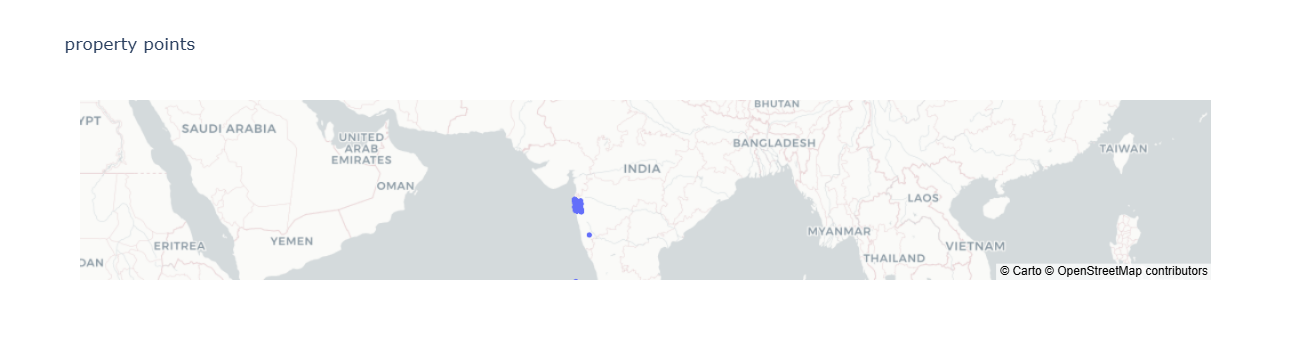

In [954]:
# Create a new DataFrame for the map
df_map = df[['lattitude', 'longitude', 'city']].copy()

# Create a map using Plotly's scatter_mapbox
fig = px.scatter_mapbox(
    df_map,
    lat='lattitude',
    lon='longitude',
    title="property points",
    hover_name="city"
)

# Update the layout for the map of India
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": 20.5937, "lon": 78.9629},  # Centered over India
    mapbox_zoom=3,
)

# Show the plot
fig.show()


In [955]:
# Filter rows where latitude starts with 16, 12, or 9 — without changing the original column
filtered_df = df[
    df['lattitude'].astype(str).str.startswith('16') |
    df['lattitude'].astype(str).str.startswith('12') |
    df['lattitude'].astype(str).str.startswith('9')
]

print(filtered_df)

                   id  price                                   flooring  \
4500   cardid69607043    1.4  vitrified, ceramic tiles, marble, granite   
4880   cardid72924469    6.5                                     marble   
11074  cardid72690581    3.2             ceramic tiles, marble, granite   
11152  cardid70755751    1.6                                  vitrified   
11806  cardid72017771    1.7                                  marbonite   

       available_units  towers    construction             ownership  bed  \
4500               NaN     NaN  10 to 15 years  co-operative society  1.0   
4880               7.0     1.0  10 to 15 years              freehold  3.0   
11074              NaN     NaN   5 to 10 years              freehold  3.0   
11152              NaN     NaN             NaN              freehold  2.0   
11806            129.0     1.0   5 to 10 years  co-operative society  2.0   

       bath  parking  ...  hospital_min_km  hospital_within_2km  \
4500    2.0      Na

`observation`
- Whole data is correct except that lattitude and longitude values, hence delete those values.

In [956]:
# Create a mask for rows where 'lattitude' starts with 16, 12, or 9
mask = (
    df['lattitude'].astype(str).str.startswith('16') |
    df['lattitude'].astype(str).str.startswith('12') |
    df['lattitude'].astype(str).str.startswith('9')
)

# Replace only 'lattitude' and 'longitude' with NaN for those rows
df.loc[mask, ['lattitude', 'longitude']] = np.nan

In [958]:
# Rearranged columns
df = df[[
    'id',
    
    # Project/Location Info
    'builder', 'project_name', 'project_in_acres', 'location', 'city',
    'lattitude', 'longitude',
    
    # Property Details
    'property_type', 'status', 'construction', 'ownership',
    'flat_on_floor', 'total_floor',
    'furnish','area', 'bed', 'bath', 'balcony', 'lift', 'parking',
    'overlooking','facing', 'flooring', 'extra_rooms','available_units','towers',
    
    # Pricing Info
    'costpersqft','emi', 'price_category', 'price',
    
    # Nearby Amenities
    'education_mean_km', 'education_min_km', 'education_within_2km',
    'transport_mean_km', 'transport_min_km', 'transport_within_2km',
    'shopping_centre_mean_km', 'shopping_centre_min_km', 'shopping_centre_within_2km',
    'commercial_hub_mean_km', 'commercial_hub_min_km', 'commercial_hub_within_2km',
    'hospital_mean_km', 'hospital_min_km', 'hospital_within_2km',
    'tourist_mean_km', 'tourist_min_km', 'tourist_within_2km',
    'overall_min_mean_km', 'overall_avg_mean_km', 'overall_min_min_km', 'overall_avg_min_km',
    'total_within_2km',
    
    # Seller
    'seller'
]]


In [959]:
# save the cleaned data

df.to_csv('../data/property_cleaned_data.csv', index=False)

In [960]:
df.to_excel('data_after_cleaning.xlsx')

In [961]:
df.shape

(11857, 55)

In [962]:
df.columns

Index(['id', 'builder', 'project_name', 'project_in_acres', 'location', 'city',
       'lattitude', 'longitude', 'property_type', 'status', 'construction',
       'ownership', 'flat_on_floor', 'total_floor', 'furnish', 'area', 'bed',
       'bath', 'balcony', 'lift', 'parking', 'overlooking', 'facing',
       'flooring', 'extra_rooms', 'available_units', 'towers', 'costpersqft',
       'emi', 'price_category', 'price', 'education_mean_km',
       'education_min_km', 'education_within_2km', 'transport_mean_km',
       'transport_min_km', 'transport_within_2km', 'shopping_centre_mean_km',
       'shopping_centre_min_km', 'shopping_centre_within_2km',
       'commercial_hub_mean_km', 'commercial_hub_min_km',
       'commercial_hub_within_2km', 'hospital_mean_km', 'hospital_min_km',
       'hospital_within_2km', 'tourist_mean_km', 'tourist_min_km',
       'tourist_within_2km', 'overall_min_mean_km', 'overall_avg_mean_km',
       'overall_min_min_km', 'overall_avg_min_km', 'total_within_2km

# This code is to be used in a VS Code script.

In [963]:
import numpy as np
import pandas as pd
import re
import ast

In [964]:
df = pd.read_csv(r'C:\Users\ABC\Desktop\bhushan\property_project\data\f_original magicbricks cleaned 12022 data.csv')

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\4202509381.py:1: DtypeWarning:

Columns (183,210,221,237,246,247,248,249,250,252,253,264,271,272,278,279,280,281,282,284,285,286,287,288) have mixed types. Specify dtype option on import or set low_memory=False.



# Perform Cleaning and Feature Building

In [965]:
def basic_cleaning(df):
    
    #convert column names into lowercase
    df.columns = df.columns.str.lower()

    #drop unwanted columns
    df.drop(['@id','@type','bhk_type' ,'locality_url','md_booking amount','md_loan offered','md_water availability','ap_price','ap_price per sqft','ap_configuration',
              'ap_pjt_url','ap_ratings','ap_reviews_by','headings_with_ratings','aboutpjt_bhk','2 bhk flat','locality_url_review','liv_environment','liv_commuting',
              'liv_places of interest','md_status of electricity','3 bhk flat','1 bhk flat','studio apartment','4 bhk flat','5 bhk flat','md_landmarks', 
              'multistorey apartment', '3 bhk villa', '4 bhk villa', 'residential plot', '2 bhk builder', '3 bhk builder','4 bhk penthouse','5 bhk penthouse', 
              'md_authority approval','6 bhk flat','rent','commercial office space','3 bhk penthouse','md_rera id','aboutpjt_launch date'],axis=1,inplace=True)
    
    #drop duplicate rows
    df.drop_duplicates(inplace=True)
    
    #delete column which have all nan values
    df.dropna(axis=1, how='all', inplace=True)

    df[df.select_dtypes('object').columns] = df.select_dtypes('object').apply(
        lambda col: col.map(lambda x: x.lower() if isinstance(x, str) else x)
    )

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #function 1
    def check_more_than_one_value_in_column(df, cols, new_col_name, col_name):
        # Step 1: Create a boolean column to check if more than one value (non-NaN) is filled in the specified columns
        df[new_col_name] = df[cols].notna().sum(axis=1) > 1
    
        # Step 2: Combine all values from the specified columns into a list for each row
        def combine_values():
            df[col_name] = [list(values) for values in zip(*[df[col] for col in cols])]
    
        combine_values()
    
        found_distinct = False
    
        # Step 3: If any row has more than one value
        if df[new_col_name].any():
            for index, row in df[col_name].items():
                non_nan_vals = [val for val in row if pd.notna(val)]
                # Step 4: If more than one unique value found in the row, print that row
                if len(set(non_nan_vals)) > 1: #take rows which have more than one unique value 
                    print(f"Row {index} has multiple distinct non-NaN values: {row}") 
                    found_distinct = True  #if get more than 1 distinct value then below thing wont run
    
        # Step 5: If no row has more than one unique value, safely pick the first non-NaN value
        if not found_distinct:
            df[col_name] = df[col_name].apply(lambda row: next((val for val in row if pd.notna(val)), None))
    
    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #function2
    def combine_first_valid(df, source_cols, new_col_name):
        """
        Create a new column with the first valid (non-null, non-'nan', non-empty) value 
        across the specified source columns.
        """
        # Combine columns into new_col_name using first valid value per row
        df[new_col_name] = df[source_cols].apply(
            lambda row: next(
                (str(x) for x in row if pd.notna(x) and str(x).strip().lower() != 'nan' and str(x).strip() != ''),
                np.nan
            ),
            axis=1
        )
        
        # Normalize the new column's casing and whitespace
        df[new_col_name] = df[new_col_name].str.strip().str.lower()
    
        # Drop the source columns
        df.drop(columns=source_cols, inplace=True)
    
        return df

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #emi
    converted_emi = []

    for emi_n in df['emi']:
        if isinstance(emi_n, str):  # Check if emi_n is a string
            if 'k' in emi_n:
                # Convert from thousands to lakhs
                converted_emi.append(float(emi_n.replace('k', '')) / 100)
            elif 'l' in emi_n:
                # No change needed for lakhs
                converted_emi.append(float(emi_n.replace('l', '')))
            else:
                # Convert rupees to lakhs
                converted_emi.append(float(emi_n) / 100000)
        else:
            # If it's already a float, convert rupees to lakhs
            converted_emi.append(emi_n / 100000)
    
    # Add the converted values to the DataFrame
    df['converted_emi'] = converted_emi
    df = df.drop(['emi'], axis=1)
    df.rename(columns={'converted_emi': 'emi'}, inplace=True)
        
    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    # numerical column
    #--------------------------------------------------------------------------------------------------------------------------------------------------------------

    #price
    def convert_price_to_cr(val):
        if isinstance(val, str):  # check if value is a string
            parts = val.replace('₹', '').split()  # remove ₹ and split into amount and unit
            if len(parts) == 2:  # ensure both amount and unit exist
                amount, unit = parts
                amount = float(amount)  
                return amount / 100 if unit.lower() == 'lac' else amount  # convert lac to Cr
        return None  # return None if invalid
    
    # Apply conversion
    df['price'] = df['price'].apply(convert_price_to_cr)

    #datatype to float
    df['price'] = df['price'].astype('float64')
    
    # Drop rows with missing prices
    df = df.dropna(subset=['price'])

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #bed
    check_more_than_one_value_in_column(df, ['numberofrooms', 'bb_beds', 'leftbb_beds', 'bb_bed','leftbb_bed'], 'multi_bed_filled','bed')  

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #bath
    check_more_than_one_value_in_column(df, ['bb_baths', 'leftbb_baths', 'bb_bath', 'leftbb_bath'], 'multi_bath_filled','bath')  

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #parking
    # Convert 'leftmany_car parking' into sum of all digits
    df['leftmany_car parking'] = df['leftmany_car parking'].apply(
        lambda x: sum(map(int, re.findall(r'\d+', str(x)))) if pd.notna(x) else np.nan
    )
    
    # Convert 'many_car parking' into sum of all digits
    df['many_car parking'] = df['many_car parking'].apply(
        lambda x: sum(map(int, re.findall(r'\d+', str(x)))) if pd.notna(x) else np.nan
    )
    
    # Take max across the four parking columns
    df['parking'] = df[
        ['bb_covered-parking', 'leftbb_covered-parking', 'many_car parking', 'leftmany_car parking']
    ].apply(
        lambda row: np.nanmax(row.values) if pd.notna(row).any() else np.nan,
        axis=1
    )

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #area and costpersqft     

    #combine_first Update null elements with value in the same location in other.
    df['area_work'] = df["many_carpet area"].combine_first(df["leftmany_carpet area"])


    # Extract carpet area features
    df["carpet_area"] = df["area_work"].apply(lambda x: float(re.match(r'([\d,\.]+)', x).group(1).replace(',', '')) if pd.notna(x) and re.match(r'^[\d,\.]+', x) else None) 
    df['cost_per_sqft'] = df['area_work'].str.extract(r'₹([\d,\.]+)')[0].str.replace(',', '').astype(float)
    df['area_unit'] = df['area_work'].str.extract(r'/([^/]+)$')
    
    # Remove unwanted area units
    df = df[~df['area_unit'].isin(['sqm', 'kanal'])]
    
    # Combine super built-up area
    df['super_build_area_work'] = df["leftmany_super built-up area"].combine_first(df["many_super built-up area"])
    
    
    # Extract super built-up features
    df['initial_unit'] = df['super_build_area_work'].apply(lambda x: ''.join([char for char in str(x)[re.match(r'\d+', str(x)).end():] if char.isalpha()])[:4] if isinstance(x, str) else None)
    df = df[~df['initial_unit'].isin(['sqms', 'sqyr'])]
    df["super_build_up_area"] = df["super_build_area_work"].apply(lambda x: float(re.match(r'([\d,\.]+)', x).group(1).replace(',', '')) if pd.notna(x) and re.match(r'^[\d,\.]+', x) else None)
    df['super_build_up_cost_per_sqft'] = df['super_build_area_work'].str.extract(r'₹([\d,\.]+)')[0].str.replace(',', '').astype(float)
    df['super_built_up_area_unit'] = df['super_build_area_work'].str.extract(r'/([^/]+)$')
    
    # Final feature selection with combine_first
    df['f_area'] = df["carpet_area"].combine_first(df["super_build_up_area"])
    df['f_costpersqft'] = df["cost_per_sqft"].combine_first(df["super_build_up_cost_per_sqft"])
    df['f_area_unit'] = df["super_built_up_area_unit"].combine_first(df["area_unit"])
    df['f_area'] = df['f_area'].astype('float')
    df['f_costpersqft'] = df['f_costpersqft'].astype('float')
    
    
    # Fill missing values from 'area' column
    df['dupli_f_area'] = np.where(
        pd.isna(df['f_area']) & pd.notna(df['area']),
        df['area'].str.extract(r'([\d,\.]+)')[0].str.replace(',', '').astype(float),
        None
    )
    
    df['dupli_f_area_unit'] = np.where(
        pd.isna(df['f_area']) & pd.notna(df['area']),
        df['area'].str.extract(r'([a-zA-Z\-]+)$')[0],
        None
    )
    
    df['dupli_price'] = df.apply(
        lambda row: row['price'] * (10**7) if pd.isna(row['f_area']) and pd.notna(row['area'])
        else None,
        axis=1
    )
    
    df['dupli_costpersqft'] = np.round(df['dupli_price'].astype('float') / df['dupli_f_area'].astype('float'), 2)
    
    # Update final columns if missing
    def update_values(df, update_cols, using_cols):
        for update_col, using_col in zip(update_cols, using_cols):
            df[update_col] = np.where(
                pd.isna(df['f_area']) & pd.notna(df['area']),
                df[using_col],
                df[update_col]
            )
        return df
    
    # Define columns to update and corresponding columns to use
    columns_to_update = ['f_costpersqft', 'f_area_unit', 'f_area']
    using_columns = ['dupli_costpersqft', 'dupli_f_area_unit', 'dupli_f_area']
    
    # Update the DataFrame
    df = update_values(df, columns_to_update, using_columns)
    
    # Drop intermediate columns
    cols_to_drop = [
        'many_carpet area', 'leftmany_carpet area', 'leftmany_super built-up area', 'many_super built-up area', 'area',
        'area_work', 'carpet_area', 'cost_per_sqft', 'area_unit', 'initial_unit',
        'super_build_area_work', 'super_build_up_area', 'super_build_up_cost_per_sqft', 'super_built_up_area_unit',
        'dupli_f_area', 'dupli_f_area_unit', 'dupli_price', 'dupli_costpersqft', 'f_area_unit'
    ]
    df.drop(columns=cols_to_drop, inplace=True)

    df = df.rename(columns={'f_area':'area','f_costpersqft':'costpersqft'})

    df['area'] = df['area'].astype('float64')

    #After analyzing, found some errors in the area column; hence, dropped the rows with the below id's
    df = df[~df['id'].isin([
        'cardid13695470', 'cardid72545677', 'cardid71119645',
        'cardid46503375', 'cardid48667071', 'cardid72200975',
        'cardid70294971', 'cardid70608749', 'cardid72754063',
        'cardid72078141', 'cardid71460761', 'cardid45089373',
        'cardid71419541', 'cardid72848693', 'cardid73238137'
    ])]

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #total_floor and flat_on_floor
    #combine_first Update null elements with value in the same location in other.
    df['floor_work_1'] = df['many_floor'].combine_first(df['leftmany_floor'])

    df['floor_work_1'] = df['floor_work_1'].astype('str') 

    df['flat_on_floor'] = df['floor_work_1'].apply(
        lambda x: x.split('(')[0].strip() if '(' in str(x) else None
    )

    df['total_floor'] = df['floor_work_1'].apply(
        lambda x: x.split('(')[1].strip() if '(' in str(x) else None
    )

    df['total_floor'] = df['total_floor'].str.extract(r'(\d+)').astype(float)
    
    df['flat_on_floor'] = df['flat_on_floor'].replace({'lower basement': -1, 'upper basement': -2,'ground':0})

    df['total_floor'] = np.where(
        pd.isna(df['total_floor']) & pd.notna(df['md_floors allowed for construction']),
        df['md_floors allowed for construction'],
        df['total_floor']
    )

    df['flat_on_floor'] = df['flat_on_floor'].astype('float64')

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #lift
    check_more_than_one_value_in_column(df, ['many_lifts', 'md_lift', 'leftmany_lifts', 'many_lift','leftmany_lift'], 'multi_lift_filled','lift') 

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #balcony
    #combine_first Update null elements with value in the same location in other.
    df['balcony'] = (
        df['bb_balcony']
        .combine_first(df['leftbb_balcony'])
        .combine_first(df['bb_balconies'])
        .combine_first(df['leftbb_balconies'])
    )
    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #longitude and lattitude
    df['lattitude'] = df['geo'].str.split(',').str[1].str.split(':').str[1].str.strip(" '\"").astype('float')
    df['longitude'] = df['geo'].str.split(',').str[2].str.split(':').str[1].str.strip(" '\"}").astype('float')

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #project_in_acres
    # Conversion function for different units to acres
    def convert_to_acres(value):
        if isinstance(value, str):  # Check if the value is a string
            if 'acre' in value:
                acres = float(value.replace('acre', '').strip())
                return round(acres, 4)  
            elif 'sq-m' in value:
                sqm = float(value.replace('sq-m', '').strip())
                return round(sqm * 0.000247105, 4)  
            elif 'sq-ft' in value:
                sqft = float(value.replace('sq-ft', '').strip())
                return round(sqft * 0.0000229568, 4)  
            elif 'hectare' in value:
                hectares = float(value.replace('hectare', '').strip())
                return round(hectares * 2.47105, 4)  
            elif 'sq-yrd' in value:
                sq_yrd = float(value.replace('sq-yrd', '').strip())
                return round(sq_yrd * 0.000836127, 4)  
        elif isinstance(value, (int, float)):  # If value is numeric
            return round(value * 0.0000229568, 4)  
        return np.nan
    
    # Apply the conversion to the column
    df['project_in_acres'] = df['aboutpjt_project size'].apply(lambda x: convert_to_acres(x))
    
    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    #categorical column
    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #builder
    df = combine_first_valid(
        df,
        source_cols=['many_developer','leftmany_developer','ap_buildr'],
        new_col_name='builder'
    )

    def standardize_property_name(name):
        """
        Standardize property names to a single consistent name.
        """
        # Define a mapping of possible variations to standardized names
        mapping = {
            "a&o realty / a and o realty / a & o realty ltd.": "a&o realty",
            "adhiraj constructions / adhiraj constructions pvt. ltd.": "adhiraj constructions",
            "arihant superstructures ltd / arihant superstructures ltd.": "arihant superstructures ltd",
            "bharat infrastructure & engineering pvt. ltd. / bharat infrastructure and engineering": "bharat infrastructure & engineering",
            "bhoomi group / bhoomi / bhoomi properties": "bhoomi group",
            "choice group of companies / choice group": "choice group",
            "darshan properties / darshan properties group": "darshan properties",
            "dev land housing / dev land housing ltd.": "dev land housing",
            "ecohomes / eco homes": "ecohomes",
            "gundecha developers / gundecha / gundecha developing milestone /gundecha group": "gundecha group",
            "hiranandani communities / hiranandani constructions / hiranandani developers / hiranandani group / house of hiranandani": "hiranandani group",
            "k raheja realty/ k. raheja realty": "k raheja realty",
            "krishna enterprise / krishna enterprises": "krishna enterprise",
            "l & t realty / l&t realty": "l&t realty",
            "lodha / lodha group": "lodha group",
            "lok housing group / lok group": "lok housing group",
            "lokhandwala builders / lokhandwala constructions / lokhandwala construction industries pvt. ltd. / lokhandwala group": "lokhandwala group",
            "lokhandwala infrastructure": "lokhandwala infrastructure",
            "lotus logistic and developers / lotus logistics & developer pvt ltd": "lotus logistics",
            "neelam realtors / neelam realtors pvt. ltd.": "neelam realtors",
            "neelsidhi group / neelsidhi": "neelsidhi group",
            "nirmal lifestyle / nirmal life style": "nirmal lifestyle",
            "omkar realtors and developers pvt. ltd. / omkar realtors": "omkar realtors",
            "parinee developers / parinee group": "parinee group",
            "platinum group / platinum group builders / platinum constructions": "platinum group",
            "prescon group / prescon": "prescon group",
            "puraniks builders / puranik builders ltd. / puranik group": "puraniks group",
            "r k builders / r k builders and developers": "r k builders",
            "qualcon properties llp / qualcon": "qualcon",
            "raheja universal (pvt.) ltd. / raheja universal pvt. ltd.": "raheja universal",
            "raheja developers / raheja developers ltd.": "raheja developers",
            "raj realty group / raj realty": "raj realty group",
            "rashmi housing pvt. ltd. / rashmi housing": "rashmi housing",
            "ravi group of builders and developers / ravi group": "ravi group",
            "rna / rna ng builders / rna corp / rna group": "rna group",
            "rohan lifescapes / rohan lifescapes ltd.": "rohan lifescapes",
            "romell group / romell real estate pvt. ltd.": "romell group",
            "rustomjee / rustomjee developers": "rustomjee",
            "sahajanand developers / sahajanand infrastructure pvt. ltd.": "sahajanand developers",
            "sainath developers / sainath group": "sainath developers",
            "sapphire group and builder / sapphire group": "sapphire group",
            "saptashree builders & developers / sapta shree builders & developers": "saptashree",
            "shapoorji pallonji real estate / shapoorji pallonji group": "shapoorji pallonji group",
            "sheth creators / sheth creators pvt. ltd.": "sheth creators",
            "shree ostwal builders ltd. / shree ostwal builders and developers": "shree ostwal builders",
            "shreedham builders and developers / shreedham group": "shreedham group",
            "shreeji construction / shreeji group / shreeji group builder and developer": "shreeji group",
            "smgk associates / smgk group": "smgk group",
            "space india / space india builders & developers": "space india",
            "spenta builders / spenta corp. pvt. ltd.": "spenta",
            "sugee realty & developers (india) pvt. ltd. / sugee group": "sugee group",
            "swastik realtors / swastik group builders & developers": "swastik",
            "tharwani realty / tharwani group": "tharwani group",
            "titanium group / titanium builders and developers": "titanium group",
            "today global homes / today global builders & developers": "today global",
            "transcon developers / transcon group": "transcon group",
            "tridhaatu realty / tridhaatu realty & infra pvt. ltd.": "tridhaatu realty",
            "vaibhavlaxmi builders & developers / vaibhavlaxmi builders and developers / vaibhav laxmi developers": "vaibhavlaxmi builders",
            "vbhc value homes pvt. ltd. / vbhc": "vbhc",
            "vihang infrastructure pvt ltd / vihang group": "vihang group",
            "vinay unique developers / vinay unique group": "vinay unique group"
        }
    
        # Handle null or missing values
        if not isinstance(name, str):
            return name
    
        # Normalize input name (e.g., lowercase, strip whitespace)
        normalized_name = name.strip().lower()
    
        # Standardize using the mapping
        for key, value in mapping.items():
            variations = key.split(" / ")
            if normalized_name in variations:
                return value
    
        # Return the original name if no match is found
        return name
    
    # Apply the function to the 'builder' column of a DataFrame
    df['builder'] = df['builder'].apply(standardize_property_name)

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #project_name
    df = combine_first_valid(
        df,
        source_cols=['ap_pjt_name', 'many_project', 'leftmany_project'],
        new_col_name='project_name'
    )

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #furnish
    df = combine_first_valid(
        df,
        source_cols=['md_furnishing','many_furnished status','leftmany_furnished status'],
        new_col_name='furnish'
    )

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #city
    df = df.rename(columns={'address':'wholeaddress'})

    df['addressregion'] = df['wholeaddress'].apply(
        lambda x: ast.literal_eval(x).get('addressregion') if isinstance(x, str) else x.get('addressregion')
    )

    
    #rename
    df = df.rename(columns={'md_address':'address'})

    df = df.rename(columns = {'addressregion':'city'})

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #location
    # Convert string representation of dictionaries to actual dictionaries
    df["wholeaddress"] = df["wholeaddress"].apply(ast.literal_eval)
    
    # Extract 'addresslocality' into a new column
    df["location"] = df["wholeaddress"].apply(lambda x: x.get("addresslocality", ""))
    
    #make rd as road in address column
    df['address'] = df['address'].astype(str).str.replace(r'\brd\b', 'road', regex=True)
    
    #if below values match found in address column,then update location with the matched value
    
    lst = [
        "mira road east", "mira road west", "mira rd east", "mira rd west",
        "vile parle east", "vile parle west", "lower parel west", "lower parel east",
        "new panvel east", "new panvel west", "grand road east", "grand road west",
        "charni road east", "charni road west", "grand rd east", "grand rd west",
        "charni rd east", "charni rd west", "kanjur marg east", "kanjur marg west",
        "mira bhayandar east", "mira bhayandar west", "marine lines east", "marine lines west",
        "ram mandir west", "ram mandir east", "vasai road west", "vasai road east",
        "matunga road west", "matunga road east", "vasai rd west", "vasai rd east",
        "matunga rd west", "matunga rd east", "rajendra nagar west", "rajendra nagar east",
        "tilak nagar west", "tilak nagar east", "diva station east", "diva station west",
        "ville parla west", "ville parla east", "lower pare west", "lower pare east",
        "mumbai central east", "mumbai central west"
    ]
    # Step 1: Filter NaN rows
    df_nan1 = df[df['location'].isna()].copy()
    
    # Step 2 & 3: Match with lst and update location
    for index, row in df_nan1.iterrows():
        for loc in lst:
            if loc in row['address'].lower():  # Case insensitive match
                df.at[index, 'location'] = loc
                break  # Stop at first match

    # Function to extract "<name> east" or "<name> west" from 'address'
    def extract_location(address):
        # Use regex to find a word followed by 'east' or 'west'
        match = re.search(r'(\w+)\s+(east|west)', address, re.IGNORECASE)
        if match:
            return f"{match.group(1)} {match.group(2)}"
        return np.nan  # If no match, return NaN
    
    # Filter the rows where 'location' is NaN
    df_nan2 = df[df['location'].isna()]
    
    # Apply the extract_location function only to the 'address' column in the filtered rows
    df.loc[df_nan2.index, 'location'] = df_nan2['address'].apply(extract_location)
    
    mapping = {"near naupada police station, thane, maharashtra" : "thane west",
            "new suyash chs naupada, thane, maharashtra" : "thane west",
            "marine lines, mumbai, maharashtra" : "marine lines",
            "kalher, thane, maharashtra" : "bhiwandi",
            "kanikiya beverly park mira road, mumbai, maharashtra" : "mira road east",
            "204, 2nd flr, ramraj bldg, nr. ram mandir, rajanpada - sector-27, navi mumbai, maharashtra" : "sector 27 rajanpada",
            "202 dhrmasetu plot no 2225 sec 19 koperkhairane, navi mumbai, maharashtra" : "sector 19 koperkhairane",
            "kashimira near whestran express hyway, mumbai, maharashtra" : "mira road east",
            "near burhani college mazgaon mumbai 10, mumbai, maharashtra" : "mazgaon",
            "ulwe sector 21, navi mumbai, maharashtra" : "sector 21 ulwe",
            "lakeshore greens by lodha, thane, maharashtra" : "dombivli west",
            "santa cruz, mumbai, maharashtra" : "santacruz",
            "kopar khairane, navi mumbai, maharashtra" : "koparkhairane",
            "1801, 18th floor, chunam lane, lamington road, grantroad e, mumbai 400007, mumbai, maharashtra" : "grant road east",
            "charkop village near dingeshwar talao and jalaram temple, mumbai, maharashtra" : "kandivali west",
            "sarfaraz iqbal heights, ymca road 3, near maratha mandir, mumbai central, mumbai, maharashtra" : "mumbai central",
            "panchseel heights, mahavir nagar, mumbai, maharashtra" : "kandivali west",
            "sector 5 pushpak nagar, navi mumbai, maharashtra" : "sector 5 pushpak nagar",
            "poonam park view, global city, virar, thane, maharashtra" : "virar west",
            "om ekdant soc, sec-19, koperkharine, near jummy tower, navi mumbai, maharashtra" : "sector 19 koperkharine",
            "sai vrindhavan koparkhairne., navi mumbai, maharashtra" : "koparkhairne",
            "owale, ghodbunder road, thane, maharashtra" : "thane west",
            "sector 21 ulwe, navi mumbai, maharashtra" : "sector 21 ulwe",
            "dombivli, mumbai, maharashtra" : "dombivli",
            "amber enclave - 3rd floor thakurli e, mumbai, maharashtra" : "thakurli east",
            "anath sai apartment, thane, maharashtra" : "thane west",
            "willingdon heights 32nd flr near tardeo rto tulsiwadi, mumbai, maharashtra" : "tardeo",
            "12th floor c2 wing treetops lodha upper thane mankoli bhiwandi thane maharashtra 421302, mumbai, maharashtra" : "bhiwandi",
            "chincholi phatak, mumbai, maharashtra" : "malad west",
            "kanakiya, mumbai, maharashtra" : "kandivali east",
            "puranik hometown kasarvadavli, mumbai, maharashtra" : "thane west",
            "boraivali w 401, mumbai, maharashtra" : "borivali west",
            "prabhadevi, mumbai, maharashtra" : "prabhadevi",
            "green road, thane, maharashtra" : "thane west",
            "lagoona, thane, maharashtra" : "thane west",
            "kasarvadavli, thane, maharashtra" : "thane west",
            "kasarvadavli, thane, maharashtra" : "thane west",
            "dr annie besant road, worli, mumbai, maharashtra 400018, india, mumbai, maharashtra" : "worli",
            "gorai 2, mumbai, maharashtra" : "gorai",
            "lodha casa lakeshore green khoni dombivli, nilje gaon, maharashtra 421204, india, thane, maharashtra" : "dombivli east",
            "diamind garden chembur, mumbai, maharashtra" : "chembur",
            "sector 17 kamothe, navi mumbai, maharashtra" : "kamothe",
            "highland complex, mumbai, maharashtra" : "kandivali east",
            "jerbai wadia road, near tata hospital, parel, mumbai, maharashtra" : "parel",
            "gokhale road, naupada thane, thane, maharashtra" : "naupada",
            "taloja phase 2, navi mumbai, maharashtra" : "taloja",
            "ghansoli sector 11, navi mumbai, maharashtra" : "ghansoli",
            "ramnagar, thane, maharashtra" : "thane west",
            "ram maruti, thane, maharashtra" : "thane west",
            "marine lines, mumbai, maharashtra" : "marine lines",
            "sector 12 vashi., navi mumbai, maharashtra" : "sector 12 vashi",
            "just opposite of mansarovar railway station, navi mumbai, maharashtra" : "mansarovar",
            "bhaskar colony, thane, maharashtra" : "thane west",
            "taloja phase 2, navi mumbai, maharashtra" : "taloja",
            "charkop sector 3charkop gaon, mumbai, maharashtra" : "kandivali west",
            "157, pantnagar, 1st building naidu colony, mumbai, maharashtra" : "ghatkopar east",
            "godrej chandivali, mumbai, maharashtra" : "chandivali",
            "kalwa, thane, thane, maharashtra" : "kalwa",
            "ghansoli, navi mumbai, maharashtra" : "ghansoli",
            "suncity corner seawoodnerul, navi mumbai, maharashtra" : "nerul",
            "lagoona, thane, maharashtra" : "dombivli east",
            "satyam apartment, sector 19, kharghar, navi mumbai, maharashtra" : "kharghar",
            "tilak nagar chembur, mumbai 400089., mumbai, maharashtra" : "chembur",
            "401, sai aakash co op housing society, plot no.23, sector 18, ulwe, navi mumbai, maharashtra" : "sector 18 ulwe",
            "palava casa bella gold, mumbai, maharashtra" : "palava",
            "near vitthal mandir kharigaon kalwa, thane, maharashtra" : "kalwa",
            "kharghar, navi mumbai, maharashtra" : "kharghar",
            "neral karjat, mumbai, maharashtra" : "neral",
            "pahhal avenue, mumbai, maharashtra" : "goregaon west",
            "157, naidu colony, pantnagar, mumbai, maharashtra" : "ghatkopar east",
            "mangalmurthy complex, temghar, thane, maharashtra" : "bhiwandi",
            "plot no b1b, sector 9, airoli navimumbai, mumbai, maharashtra" : "sector 9 airoli",
            "chikhloli jambul phata, thane, maharashtra" : "chikhloli",
            "bapu nagar apartment., thane, maharashtra" : "bapu nagar",
            "crown taloja by lodha, taloja bypass phata, antarli, maharashtra 421204, mumbai, maharashtra" : "taloja",
            "morya garden residency vichumbe, navi mumbai, maharashtra" : "new panvel east",
            "sec-19, navi mumbai, maharashtra" : "sector 19 navi mumbai",
            "siddhivinayak appartment airoli diva koliwada near airoli mulund bridge diva goan gavthan, navi mumbai, maharashtra" : "airoli",  
            "kalher, thane, maharashtra" : "kalher",  
            "vinay nagar, mira road, mumbai, maharashtra" : "mira road east",
            "shree siddhivinayak tower vartaknagar, thane, maharashtra" : "vartaknagar",
            "kasarwadvali godbandar road thane, thane, maharashtra" : "kasarwadvali",  
            "panvel matheran road opp balaji symphony sukapur, navi mumbai, maharashtra" : "panvel",
            "sector 19, shahbaz gaon, cbd belapur, navi mumbai, navi mumbai, maharashtra" : "cbd belapur",
            "gamdevi grant road, mumbai, maharashtra" : "gamdevi",
            "dongri sandhurst road, mumbai, maharashtra" : "dongri",
            "casa rio arebiana, thane, maharashtra" : "thane",
            "lalani dreams residency, village dahivali turfe nid, taluka karjat, mumbai, maharashtra" : "karjat",
            "lodha crown akbar camp road kolshet mumbai maharashtra, mumbai, maharashtra" : "kolshet",  
            "202 sai shruti residency plot c 30 sector 4 khanda colony new panvel 410206, navi mumbai, maharashtra" : "new panvel",  
            "casa milano 12th floor - lodha palava phase 2 dombivali kalyan, navi mumbai, maharashtra" : "dombivli",  
            "203, sunrise glory shilphata near daighar police station, navi mumbai, maharashtra" : "shilphata", 
            "dronagiri navi mumbai., mumbai, maharashtra" : "dronagiri",  
            "muthaval, thane, maharashtra" : "muthaval",  
            "sector 5 koperkhairne navi mumbai, navi mumbai, maharashtra" : "koperkhairne",  
            "304, audumber chaya chsl, patilwadi, savarkar nagar, behind thakur college, thane, maharashtra" : "thane west",
            "old panvel near savarkar chowk., navi mumbai, maharashtra" : "old panvel",  
            "opposite j p international school haranwadi naka, mahim road, palghar, palghar, maharashtra" : "palghar",
            "tower 13 2003 runwal gardens dombivali, thane, maharashtra" : "dombivli",
            "village boisar, tal palghar, dist. thane, palghar, maharashtra" : "boisar",  
            "century bazar near chroma showroom, mumbai, maharashtra" : "century bazar",  
            "d/305., palghar, maharashtra" : "palghar",  
            "e 2 303 gaurav citymira road area, mumbai, maharashtra" : "mira road east",
            "umiya darshan chs, nerul sec 50 new, navi mumbaiseawoods, navi mumbai, maharashtra" : "seawoods",  
            "rambhau mhalgi marg, besides shrushti residency, khambalpada, thakurli e, dombivli e, thane, maharashtra" : "thakurli east",
            "ramabai paradise opp garden city tawor mira road thane, mumbai, maharashtra" : "mira road",  
            "siddhivinayak florentia garden citymira bhayandar, mumbai, maharashtra" : "mira bhayandar",  
            "bonkode sector 12, navi mumbai, maharashtra" : "sector 12 bonkode",  
            "vasant villa, padmavati devi marg, iit market, powai, mumbai 400076, mumbai, maharashtra" : "powai",  
            "novapark co opp housing society ltd flat no 303 plot no 68., navi mumbai, maharashtra" : "navi mumbai",
            "mira road area, mumbai, maharashtra" : "mira road",  
            "near divya heights in sector 26 navi mumbai, navi mumbai, maharashtra" : "sector 26 navi mumbai",
            "ganesh nagar, near boisar railway starion, palghar, maharashtra" : "boisar",  
            "c-001 nand dham building kashimira mira road, mumbai, maharashtra" : "mira road east",
            "om sankalp chs, kopar road, thane 421202, thane, maharashtra" : "dombivli west",
            "svarna kojagiri, mumbai, maharashtra" : "goregaon east",
            "unique aurum, poonam garden, thane, maharashtra" : "mira road east",
            "neelkanth darshan society b-203125a near hotel panvel palaceold panvel, mumbai, maharashtra" : "old panvel",
            "mira road kanakia, thane, maharashtra" : "mira road east",
            "panvel, navi mumbai, navi mumbai, maharashtra" : "navi mumbai",
            "chitalsar manpada, thane, maharashtra" : "manpada",  
            "near raj kamal studio, parel, mumbai, maharashtra" : "parel",  
            "nilje station road, nilje, thane, maharashtra" : "nilje", 
            "flat no-604, plot no-4, sector 14, taloja, navi mumbai, maharashtra" : "taloja",  
            "jethe tower, 701, ambawadi, opp. ambawadi bus stop, borivali e. mumbai-400068, mumbai, maharashtra" : "borivali east",  
            "lodha crown viva, flat 1006, 10th flr tower 5, majiwada, thane, mumbai, maharashtra" : "majiwada",  
            "sunbeam heritage hsg soc, sector 4c, khanda colony asudgoan panvel, navi mumbai, maharashtra" : "panvel",
            "lodha upper thane, treetops, thane, maharashtra" : "upper thane",  
            "aanandi park a101 behind ganapati mandir durgesh park kalher bhiwandi, thane, maharashtra" : "kalher",  
            "a-9/201 tejaswi apt, near st. thomas church, sai baba nagar, mira road., mumbai, maharashtra" : "mira road east",
            "sector 11, next to miraj cinema, navi mumbai, maharashtra" : "sector 11",
            "aster, regency anantham, dombivli, mumbai, maharashtra" : "dombivli",  
            "chand nagar, near baba medical, thane, maharashtra" : "thane", 
            "thane majiwada lodha complex opp-water tank, thane, maharashtra" : "majiwada",  
            "near kalidas natyamamdir, mumbai, maharashtra" : "mulund west",
            "badlapur, thane, maharashtra" : "badlapur",  
            "near mittal club, palghar, maharashtra" : "palghar",  
            "shree krupa apt flat no 102 plot144145 sector10 new panvel navi mumbai, navi mumbai, maharashtra" : "new panvel",  
            "sector 20, cbd belapur opp bank of india  park, adjacent to hansraj building, navi mumbai, maharashtra" : "sector 20 cbd belapur",  
            "brahmand patlipada link road, opp tulsi hotel, thane, maharashtra" : "thane",  
            "gurukiran socity airoli sector 30 gothavali, navi mumbai, maharashtra" : "sector 30 gothavali"}
    
    # Fill "location" based on "address" matching mapping dictionary
    df.loc[df["location"].isna(), "location"] = df["address"].map(mapping)

    # Mapping dictionary
    replace_dict = {
        "bhayander": "bhayandar",
        "century Bazar": "century bazaar",
        "dombivali": "dombivli",
        "kasarwadvali": "kasarvadavali",
        "koparkhairane": "kopar khairane",
        "koparkhairne": "kopar khairane",
        "koperkhairne": "kopar khairane",
        "koperkhairane": "kopar khairane",
        "koperkharine": "kopar khairane",
        "mulund goregaon link road": "goregaon mulund link road",
        "naigoan": "naigaon",
        "nalasopara": "nala sopara",
        "nallasopara": "nala sopara",
        "palaspe phata": "palaspa",
        "palava": "palava city",
        "shil phata": "shilphata",
        "vartaknagar": "vartak nagar",
        "vileparle": "vile parle",
        "4 east": "ulhasnagar",
        "402borivali west": "borivali west",
        "adai": "adai navi mumbai"  # Careful with this if "adai" alone is meant to be corrected
    }
    
    # Function to apply mapping
    def correct_location(location):
        for wrong, correct in replace_dict.items():
            if pd.notnull(location) and wrong.lower() in location.lower():
                # Replace wrong word with correct one (case-insensitive)
                location = location.lower().replace(wrong.lower(), correct.lower())
        return location
    
    # Apply correction function
    df['location'] = df['location'].apply(correct_location)

    location_mapping = {
        "mulund airoli road": "navi mumbai",
        "taloja bypass road": "navi mumbai",
        "panvel": "navi mumbai",
        "sector 9 airoli": "navi mumbai",
        "taloja": "navi mumbai",
        "old panvel": "navi mumbai",
        "naigaon east vasai link road": "palghar",
        "naigaon palghar": "palghar",
        "vasai": "palghar",
        "vasai east": "palghar",
        "vasai road west": "palghar",
        "vasai west": "palghar",
        "virar": "palghar",
        "virar east": "palghar",
        "virar west": "palghar",
        "thane west": "thane",
        "kolshet": "thane",
        "majiwada": "thane",
        "kandivali east": "mumbai",
        "thane belapur road": "thane",
        "mahim": "mumbai",
        "bhayandar": "thane",
        "bhayandar east": "thane",
        "bhayandar west": "thane",
        "bhayandarpada": "thane",
        "mira bhayandar": "thane",
        "mira bhayandar road": "thane",
        "mira road": "thane",
        "mira road area": "thane",
        "mira road east": "thane",
        "nala sopara": "palghar",
        "naigaon east": "palghar",
        "naigaon west": "palghar",
        "nala sopara east": "palghar",
        "nala sopara west": "palghar",
        "kharghar": "navi mumbai"
    }

    
    # Update city based on location presence
    for key, value in location_mapping.items():
        df.loc[df["location"].str.contains(key, case=False, na=False), "city"] = value

    df['location'] = df['location'].replace('', np.nan)

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    # property_type : New property, Resale, Rent, Other
    #combine_first Update null elements with value in the same location in other.
    df['property_type'] = df["many_transaction type"].combine_first(df["leftmany_transaction type"])

    df = df[~df['property_type'].isin(['other', 'rent'])]

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    # ownership
    df = df.rename(columns={'md_type of ownership': 'ownership'})

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #status
    #combine_first Update null elements with value in the same location in other.
    df['status'] = df['many_status'].combine_first(df['leftmany_status'])

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #construction
    #combine_first Update null elements with value in the same location in other.
    df['construction_1'] = df['many_age of construction'].combine_first(df['leftmany_age of construction'])

    df = df.rename(columns={'md_age of construction': 'construction'})

    df['construction'] = df.apply(
        lambda row: 'under construction' if row['status'] == 'under construction' else row['construction'], axis=1
    )

    df['status'] = df.apply(
        lambda row: 'under construction' if row['construction'] == 'under construction' else row['status'], axis=1
    )

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #extra rooms 
    #combine_first Update null elements with value in the same location in other.
    df['balcony1'] = df['leftmany_additional rooms'].combine_first(df['many_additional rooms'])
    
    df['extra_room'] = df['balcony1'].str.split(' ').str[1].str.strip()
    
    result = df['extra_room'].apply(
        lambda x: any(str(x) in str(room) for room in df['md_additional rooms']) if pd.notnull(x) else False
    )
    
    #sort value alphabetically 
    df['extra_rooms'] = df['md_additional rooms'].apply(
        lambda x: ', '.join(sorted(x.split(', '))) if pd.notna(x) else None
    )
    
    #remove none of these eg:from these 'none of these, store' and keep only store 
    #but if we have only 'none of these' then we keep that as it is 
    #also remove room word from all values 
    
    df['extra_rooms'] = df['md_additional rooms'].apply(
        lambda x: x if pd.isna(x) or str(x).strip() == 'none of these' else ', '.join(
            [item.replace(' room', '') for item in str(x).split(', ') if item != 'none of these']
        )
    )

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #Facing
    #combine_first Update null elements with value in the same location in other.
    df['facing'] = df['leftmany_facing'].combine_first(df['many_facing'])

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #towers and available_units
    df = df.rename(columns={'aboutpjt_total units': 'available_units', 
                        'aboutpjt_total towers': 'towers'})

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #seller
    df['seller'] = df['potentialaction'].str.split(',').str[1].str.split(':').str[2].str.strip(" '\"")

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #price_category
    # Define price bins and labels
    price_bins = [0, 0.99, 1.99, 2.99, 3.99, 4.99, 5.99, 6.99, 7.99, 8.99, 9.99, 14.99, 20.00, float('inf')]
    price_labels = [
        "0.00 - 0.99", "1.00 - 1.99", "2.00 - 2.99", "3.00 - 3.99", "4.00 - 4.99", 
        "5.00 - 5.99", "6.00 - 6.99", "7.00 - 7.99", "8.00 - 8.99", "9.00 - 9.99", 
        "10.00 - 14.99", "15.00 - 20.00", "20.00 and above"
    ]
    
    # Use pd.cut to categorize the prices
    df['price_category'] = pd.cut(df['price'], bins=price_bins, labels=price_labels, right=True)

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #overlooking
    df['overlooking'] = df['md_overlooking'].apply(
        lambda x: ', '.join(sorted(map(str.strip, x.split(',')))) if pd.notna(x) else np.nan
    )
    
    # Remove the phrase 'not available' from the 'overlooking' column
    df['overlooking'] = df['overlooking'].str.replace(',? *not available', '', regex=True)

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #room_type
    df['room_type'] = df['name'].apply(lambda x: 'flat' if 'flat' in x else ('apartment' if 'apartment' in x else 'other'))

    #drop apartment rows
    df = df[df['room_type'] != 'apartment']

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------

    #nearby_location_km

    # Reusable function
    def combine_columns(df, cols, new_col):
        df[new_col] = df[cols].apply(lambda row: ', '.join(filter(pd.notna, row)), axis=1)
    
    # Education
    combine_columns(df, [
        'educational institute_1', 'educational institute_2', 
        'educational institute_3', 'educational institute_4', 
        'educational institute_5'
    ], 'education')
    
    # Transport
    combine_columns(df, [
        'transportation hub_1', 'transportation hub_2', 
        'transportation hub_3', 'transportation hub_4', 
        'transportation hub_5'
    ], 'transport')
    
    # Shopping Centre
    combine_columns(df, [
        'shopping centre_1', 'shopping centre_2', 
        'shopping centre_3', 'shopping centre_4', 
        'shopping centre_5'
    ], 'shopping_centre')
    
    # Commercial Hub
    combine_columns(df, [
        'commercial hub_1', 'commercial hub_2', 
        'commercial hub_3', 'commercial hub_4', 
        'commercial hub_5'
    ], 'commercial_hub')
    
    # Hospital
    combine_columns(df, [
        'hospital_1', 'hospital_2', 
        'hospital_3', 'hospital_4', 
        'hospital_5'
    ], 'hospital')
    
    # Tourist
    combine_columns(df, [
        'tourist spot_1', 'tourist spot_2', 
        'tourist spot_3', 'tourist spot_4'
    ], 'tourist')

    # Function to extract mean km from text
    # Initialize global zero counter
    zero_count = 0
    
    # Function to extract mean km with zero replacement
    def extract_mean_km(text):
        global zero_count
        if pd.isna(text):
            return np.nan
        km_values = [float(x) for x in re.findall(r'([\d.]+)\s*km', text)]
        if any(km == 0.0 for km in km_values):
            zero_count += 1
            km_values = [0.0001 if km == 0.0 else km for km in km_values] #reason for this code given below 
        return sum(km_values) / len(km_values) if km_values else np.nan
    
    # Function to extract min km with zero replacement
    def extract_min_km(text):
        if pd.isna(text):
            return np.nan
        km_values = [float(x) for x in re.findall(r'([\d.]+)\s*km', text)]
        km_values = [0.0001 if km == 0.0 else km for km in km_values]
        return min(km_values) if km_values else np.nan
    
    # Apply to column
    df['education_mean_km'] = df['education'].apply(extract_mean_km)
    df['education_min_km'] = df['education'].apply(extract_min_km)
    
    # Print your zero count!
    #print(f"\nRows containing zero km replaced: {zero_count}") #print no of zero km values in data , 
                                                                #means something which is in zero km , like hospital in building so it become zero km
                                                                #for such data make 0.0001 km just make identify them as there is location of hospital or any other 
                                                                #if we keep 0 km only then it may means that there is no location for that property 
                                                                #if any there is hospital location which is inside building or something then it become 0.0 km so this get counut as 1
                                                                #in hospital_within_2km
    
    
    # Function to count places within 2 km
    #so one row has so many values and from that how many are within 2km that we count here
    #eg: [1.0,3.0,1.9,4.8] so here it is 2
    def count_within_2km(text):
        if pd.isna(text):
            return np.nan
        km_values = [float(x) for x in re.findall(r'([\d.]+)\s*km', text)]
        return sum(1 for km in km_values if km <= 2.0)
    
    # List of combined location columns
    location_cols = ['education', 'transport', 'shopping_centre', 'commercial_hub', 'hospital', 'tourist']
    
    # Apply all 3 functions: mean, min, within_2km
    for col in location_cols:
        df[col + '_mean_km'] = df[col].apply(extract_mean_km)
        df[col + '_min_km'] = df[col].apply(extract_min_km)
        df[col + '_within_2km'] = df[col].apply(count_within_2km)
    
    # Show only mean and min columns
    mean_cols = [col + '_mean_km' for col in location_cols]
    min_cols = [col + '_min_km' for col in location_cols]
    within_2km_cols = [col + '_within_2km' for col in location_cols]
    
    # Add final 5 summary columns
    df['overall_min_mean_km'] = df[mean_cols].min(axis=1)
    df['overall_avg_mean_km'] = df[mean_cols].mean(axis=1)
    df['overall_min_min_km'] = df[min_cols].min(axis=1)
    df['overall_avg_min_km'] = df[min_cols].mean(axis=1)
    df['total_within_2km'] = df[within_2km_cols].sum(axis=1) #sum of all within_2km location_cols

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------

    #flooring
    df = df.rename(columns={'md_flooring':'flooring'})

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------

    #amenities
    # Select columns that start with 'am_' and include 'id'
    am_cols = ['id'] + [col for col in df.columns if col.startswith('am_')]
    
    # Create a separate DataFrame with those columns
    am_df = df[am_cols].copy()
    
    # Drop 'am_' columns from the original DataFrame (keep 'id')
    df = df.drop(columns=[col for col in df.columns if col.startswith('am_')])

    #--------------------------------------------------------------------------------------------------------------------------------------------------------------

    #Custom data corrections and row-level cleaning

    # List of IDs to remove
    ids_to_remove = [
        'cardid70421965',  
        'cardid71698587',
        'cardid41440251',
        'cardid70017925',  
        'cardid73050463',
        'cardid49131617',
        'cardid72273473',
        'cardid66762427',
        'cardid70615879',
        'cardid72819785',
        'cardid71143703',
        'cardid72821117',
        'cardid72884955',
        'cardid72803713',
        'cardid73037481',
        'cardid69783235',
        'cardid73144165',
        'cardid33966233',
        'cardid73046249',
        'cardid69702399',
        'cardid54078457',
        'cardid71697753'
    ]
    
    # Drop rows with matching IDs
    df = df[~df['id'].isin(ids_to_remove)].reset_index(drop=True)
    
    #after observation 
    ids_to_update = ['cardid73059851', 'cardid72926775', 'cardid58806131']
    
    df.loc[df['id'].isin(ids_to_update), 'city'] = 'palghar'
    df.loc[df['id'].isin(ids_to_update), 'location'] = 'palghar'
    
    #assign 'thane' to the city for all rows where location is 'ulhasnagar'
    df.loc[df['location'] == 'ulhasnagar', 'city'] = 'thane'
    df.loc[df['location'] == 'agashi', 'city'] = 'palghar'
    df.loc[df['location'] == 'bhabola', 'city'] = 'palghar'
    df.loc[df['location'] == 'bolinj', 'city'] = 'palghar'
    df.loc[df['location'] == 'diwanman', 'city'] = 'palghar'
    df.loc[df['location'] == 'dongarpada road', 'city'] = 'palghar'
    df.loc[df['location'] == 'evershine city', 'city'] = 'palghar'
    df.loc[df['location'] == 'juchandra', 'city'] = 'thane'
    df.loc[df['location'] == 'morya nagar', 'city'] = 'palghar'
    df.loc[df['location'] == 'oswal nagari', 'city'] = 'thane'
    df.loc[df['location'] == 'padmavati nagar bolinj', 'city'] = 'palghar'
    df.loc[df['location'] == 'unique garden', 'city'] = 'thane'
    df.loc[df['location'] == 'rustomjee global city', 'city'] = 'palghar'
    df.loc[df['location'] == 'wagholi', 'city'] = 'thane'
    df.loc[df['location'] == 'vinay nagar', 'city'] = 'thane'
    df.loc[df['location'] == 'yashwanth nagar', 'city'] = 'palghar'
    df.loc[df['location'] == 'dongarpada', 'city'] = 'palghar'
    df.loc[df['location'] == 'beverly park', 'city'] = 'thane'
    df.loc[df['location'] == 'padrikhan wadi', 'city'] = 'palghar'
    df.loc[df['location'] == 'medetiya nagar', 'city'] = 'thane'
    df.loc[df['location'] == 'hatkesh udhog nagar', 'city'] = 'thane'
    df.loc[df['location'] == 'kashigaon', 'city'] = 'thane'
    df.loc[df['location'] == 'kashimira', 'city'] = 'thane'
    df.loc[df['location'] == 'sector 8 shanti nagar', 'city'] = 'thane'
    df.loc[df['location'] == 'shanti vihar', 'city'] = 'thane'
    df.loc[df['location'] == 'chulne', 'city'] = 'palghar'
    df.loc[df['location'] == 'mahajan wadi', 'city'] = 'thane'
    df.loc[df['location'] == 'sector 9 shanti nagar', 'city'] = 'thane'
    df.loc[df['location'] == 'chandan shanti', 'city'] = 'thane'
    df.loc[df['location'] == 'pleasant park', 'city'] = 'thane'
    df.loc[df['location'] == 'sector 3 shanti nagar', 'city'] = 'thane'
    df.loc[df['location'] == 'poonam sagar complex', 'city'] = 'thane'
    df.loc[df['location'] == 'stella', 'city'] = 'palghar'
    df.loc[df['location'] == 'ramdev park', 'city'] = 'thane'
    df.loc[df['location'] == 'golden nest phase 1', 'city'] = 'thane'
    df.loc[df['location'] == 'madhuban township', 'city'] = 'palghar'
    
    # Update city to 'thane' where address starts with 'mira' (case insensitive)
    df.loc[df['address'].str.lower().str.startswith('mira', na=False), 'city'] = 'thane'
    
    #make thane in city for all this ids
    ids_to_update = [
        "cardid72703033",
        "cardid69846363",
        "cardid73257889",
        "cardid56191653",
        "cardid72796607",
        "cardid73026297",
        "cardid72794677",
        "cardid66964031",
        "cardid58541153",
        "cardid73076791",
        "cardid72794677",
        "cardid53323155",
        "cardid69812109",
        "cardid69665873",
        "cardid70673145",
        "cardid70120173",
        "cardid60101171",
        "cardid73012265",
        "cardid73028981",
        "cardid71481487",
        "cardid67617413",
        "cardid53977959"
        
    ]
    
    df.loc[df['id'].isin(ids_to_update), 'city'] = 'thane'
    
    #make palghar in city for all this ids
    ids_to_update = [
        "cardid72923721",
        "cardid61647785",
        "cardid70476757",
        "cardid72179863",
        "cardid72846389",
        "cardid73127129",
        "cardid61883771",
        "cardid72998493",
        "cardid73114181",
        "cardid71923233",
        "cardid63887703",
        "cardid72831163"
    ]
    
    df.loc[df['id'].isin(ids_to_update), 'city'] = 'palghar'
    
    #make navi mumbai in city for all this ids
    ids_to_update = [
        "cardid62724753"
    ]
    
    df.loc[df['id'].isin(ids_to_update), 'city'] = 'navi mumbai'


    #--------------------------------------------------------------------------------------------------------------------------------------------------------------



    # Create a mask for rows where 'lattitude' starts with 16, 12, or 9
    mask = (
        df['lattitude'].astype(str).str.startswith('16') |
        df['lattitude'].astype(str).str.startswith('12') |
        df['lattitude'].astype(str).str.startswith('9')
    )
    
    # Replace only 'lattitude' and 'longitude' with NaN for those rows
    df.loc[mask, ['lattitude', 'longitude']] = np.nan

















    
    





    #--------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    #drop columns
    df.drop(['numberofrooms','bb_beds','leftbb_beds','bb_bed','leftbb_bed','multi_bed_filled','bb_baths','leftbb_baths','bb_bath','leftbb_bath','multi_bath_filled',
             'bb_covered-parking','leftbb_covered-parking','many_car parking','leftmany_car parking','md_price breakup','property_loc','many_transaction type',
             'leftmany_transaction type','many_type of ownership','leftmany_type of ownership','many_status', 'leftmany_status','many_lifts','md_lift','leftmany_lifts',
             'many_lift','leftmany_lift','multi_lift_filled','aboutpjt_total floors','floor_work_1','many_floor','leftmany_floor','md_floors allowed for construction',
             'construction_1','many_age of construction','leftmany_age of construction','bb_balcony', 'leftbb_balcony', 'bb_balconies','leftbb_balconies',
             'leftmany_additional rooms', 'balcony1', 'many_additional rooms','extra_room', 'md_additional rooms','leftmany_facing','many_facing','ap_unit','ap_tower',
             'ap_tower & unit','geo','potentialaction','md_overlooking','room_type','aboutpjt_project size','educational institute_1','educational institute_2',
             'educational institute_3','educational institute_4','educational institute_5','transportation hub_1','transportation hub_2','transportation hub_3',
             'transportation hub_4','transportation hub_5','shopping centre_1','shopping centre_2','shopping centre_3','shopping centre_4','shopping centre_5',
             'commercial hub_1','commercial hub_2','commercial hub_3','commercial hub_4','commercial hub_5','hospital_1','hospital_2','hospital_3','hospital_4','hospital_5',
             'tourist spot_1','tourist spot_2','tourist spot_3','tourist spot_4','education', 'transport', 'shopping_centre', 'commercial_hub', 'hospital', 'tourist',
             'url','image','image_urls','name','wholeaddress','address','locality_rank', 'locality_url_rating'
            ],axis=1,inplace=True)
    print(df.shape)
    print(df.columns)
    #return df,am_df
    
df = basic_cleaning(df)

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\3266139791.py:97: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\3266139791.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\ABC\AppData\Local\Temp\ipykernel_9956\3266139791.py:32: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

(11857, 55)
Index(['id', 'price', 'flooring', 'available_units', 'towers', 'construction',
       'ownership', 'emi', 'bed', 'bath', 'parking', 'area', 'costpersqft',
       'flat_on_floor', 'total_floor', 'lift', 'balcony', 'lattitude',
       'longitude', 'project_in_acres', 'builder', 'project_name', 'furnish',
       'city', 'location', 'property_type', 'status', 'extra_rooms', 'facing',
       'seller', 'price_category', 'overlooking', 'education_mean_km',
       'education_min_km', 'education_within_2km', 'transport_mean_km',
       'transport_min_km', 'transport_within_2km', 'shopping_centre_mean_km',
       'shopping_centre_min_km', 'shopping_centre_within_2km',
       'commercial_hub_mean_km', 'commercial_hub_min_km',
       'commercial_hub_within_2km', 'hospital_mean_km', 'hospital_min_km',
       'hospital_within_2km', 'tourist_mean_km', 'tourist_min_km',
       'tourist_within_2km', 'overall_min_mean_km', 'overall_avg_mean_km',
       'overall_min_min_km', 'overall_avg_min_